# Training

Now we have it all centered, it's time to get those lovely sprites into a Pandas Dataframe.

In [16]:
import os
os.getcwd() 

'C:\\Users\\lee.joshi-jones\\AnacondaProjects\\GitHub\\neuralmon'

In [2]:
from utility.load import load_dataframe

gen_folders = {    
    "gen01_red-green" : 151,
    "gen01_yellow" : 151,
    "gen02_crystal" : 251,
    "gen02_gold" : 251,
    "gen02_silver" : 251,
    "gen03_emerald" : 386,
    "gen03_firered-leafgreen" : 151,
    "gen03_ruby-sapphire" : 386,
    "gen04_diamond-pearl" : 493,
    "gen04_heartgold-soulsilver" : 386,
    "gen04_platinum" : 386
}

df = load_dataframe(gen_folders)

To evaluate some results we will get, let's write some Visualization routines for test cases, and test them with some random Pokémons.

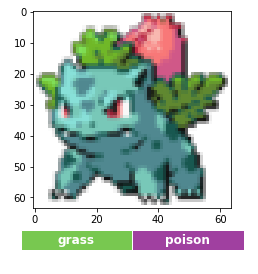

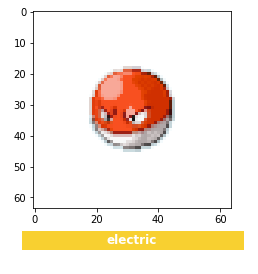

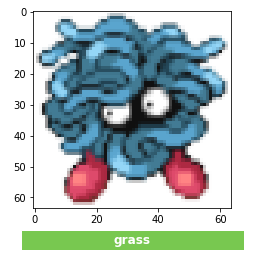

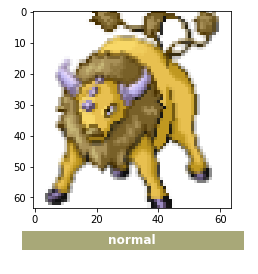

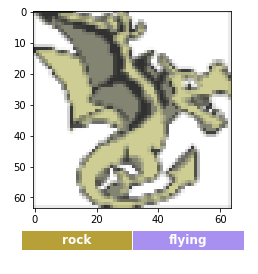

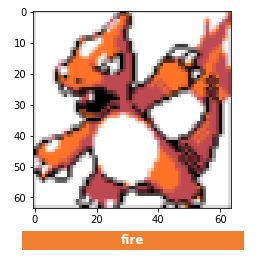

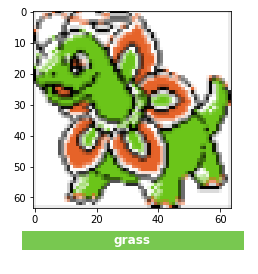

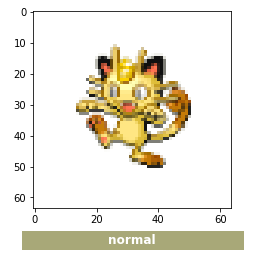

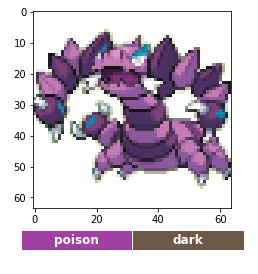

In [3]:
%matplotlib inline
from utility.plot import plot_record

for i in range(1,3500,400):
    plot_record(df.loc[i])
    

## Let's now create three numpy-arrays.
- pkm_sprites: N x 64 x 64 x 3 Array that contains the Pokémon Sprites (Out independent variables)
- pkm_types: N Array that contains the Pokémon Primary Types
- pkm_ids: N Array that contains the Pokémon ID for Safekeeping

At the end, we split the data in Train and test, using a 20% test size.

This arrays will be fed into the Machine Learning Algorithm in the next step.

In [4]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split

#Getting unique ID List
id_list = df["id"].unique()

#Splitting the ID list in Test IDs and Train IDs
id_train, id_test = train_test_split(id_list,test_size=0.3, random_state = 42)

#Getting ours dataframes splitted acording to thoses lists
df_train = df[df["id"].isin(id_train)]
df_test = df[df["id"].isin(id_test)]

def get_xy(df):
    rows = df.values.shape[0]
    arr_x = np.zeros((rows,64,64,3))
    arr_y = df["type_01"].values.reshape(-1,1)
    
    for i in range(0,rows):
        arr_x[i] = df["sprite"].iloc[i]
    
    y_domain = np.array(range(1,19)).reshape(-1,1)
    oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder.fit(y_domain)
    arr_y = oh_encoder.transform(arr_y).toarray()
    
    return arr_x, arr_y

x_train, y_train = get_xy(df_train)
x_test, y_test = get_xy(df_test)
    

# Building the Model

At least, let's get started with the Machine learning stuff. As you will see, it's quite a small step after you got yourself a nice and clean dataset.

We are using Keras running over Tensorflow to build the Convolutional Neural Network. The network architecture consists of the following:

- Convolution Layer: 32 5x5 filters
- Max Pooling Layer: 2x2, with a (2,2) stride
- Convolution Layer: 64 5x5 filters
- Max Pooling Layer: 2x2, with a (2,2) stride
- Flatten Layer: Getting out data ready for the fully connected layers
- Dense Layer: 64 neurons
- Output Layer: 18 neurons (Equal to prediction classes) with a softmax activation function

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten

#Defining model Architecture
model = Sequential([
        Convolution2D(32, 5, 5, input_shape=(64,64,3), dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
        
        Convolution2D(64, 5, 5, dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
    
        Flatten(),
        
        Dense(64),
        Activation("relu"),
        Dense(18),
        Activation("softmax")
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Fitting the model
model.fit(x_train,y_train,batch_size=64,nb_epoch=20,validation_data=(x_test,y_test),shuffle=True)
model.save_weights("./models/model_01.hdf5")

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), data_format="channels_last", input_shape=(64, 64, 3...)`
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), data_format="channels_last")`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('T

Train on 2279 samples, validate on 964 samples
Epoch 1/20


KeyboardInterrupt: 

Now, let's evaluate some performance metrics for out model. Here, we will calculate 3 metrics:
- Accuracy: Percentage of records correctly classified by the model
- Precision: Percentege of the records classified as a class that were, in fact, of that class
- Recall: Percentage of  the records with a true class of X that were classified by the model as X

As we will fine tune out model after this step, let's write a reusable function to do our dirty job later.

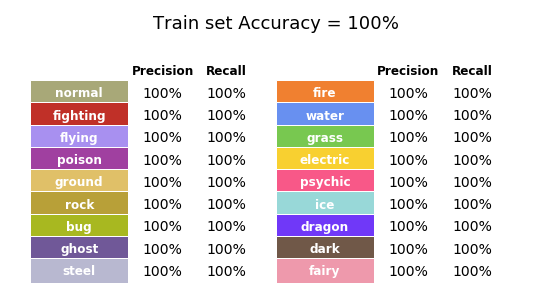

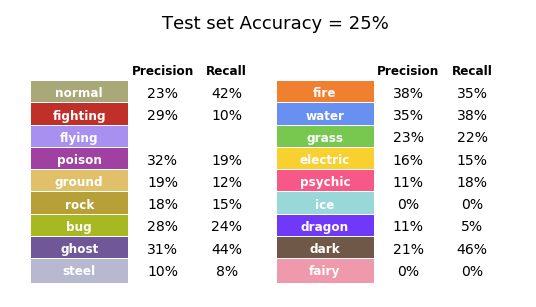

In [24]:
%matplotlib inline
from utility.plot import plot_evaluation

model.load_weights("./models/model_01.hdf5")
#Predicting values for test and train for model evaluation
pred_test = model.predict(x_test)
pred_train = model.predict(x_train)

#Computing metrics for train
plot_evaluation("Train set",y_train,pred_train)

#Computing metrics for test
plot_evaluation("Test set",y_test,pred_test)


Although we have a perfect accuracy of 100% on the training data, the test data performs much worse, with only 25% accuracy, suggesting that out model is overfiting the data.

Given the small size of the dataset, this is to be expected. Let's try to apply some Dataset Augmentation Techniques to our data to see if we can improve things. Below, we create a Keras ImageDataGenerator, that will apply a series of random transformations to our images.

We try this pipeline on a Bulbasaur sprite from the fifth generation

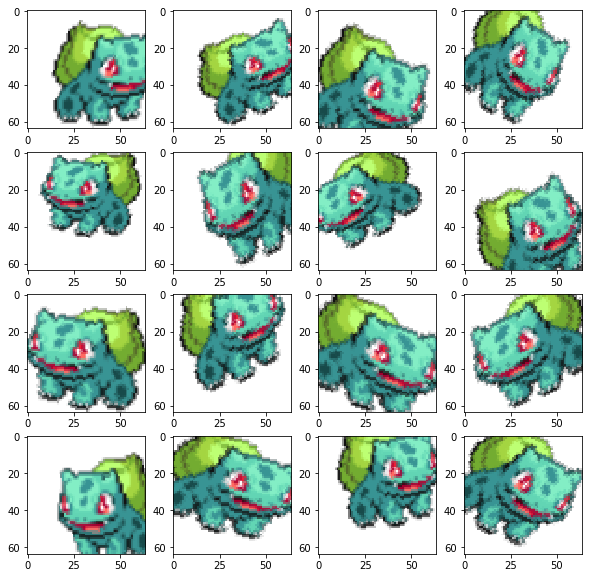

In [42]:
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

data_aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    dim_ordering="tf"
)

image = df.loc[(df["id"] == 1) & (df["gen"] == "gen05_black-white"),"sprite"].iloc[0]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(4,4, height_ratios = (1,1,1,1), width_ratios=(1,1,1,1))

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    plt.imshow(color.hsv2rgb(batch[0]))
    i += 1
    if i > 15:
        break


Now that we have our generator, let fit our model. We create a new object, with the same structure as the last one, but this time we call the fit_generator method on the model.

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout

#Defining model Architecture
model = Sequential([
        Convolution2D(32, 5, 5, input_shape=(64,64,3), dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
        
        Convolution2D(64, 5, 5, dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
    
        Flatten(),
        
        Dense(64),
        Activation("relu"),
        Dense(18),
        Activation("softmax")
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Fitting the model (30 epochs)
model.fit_generator(
    data_aug.flow(x_train,y_train, batch_size=64),
    nb_epoch=30,
    verbose=2,
    validation_data=(x_test,y_test),
    samples_per_epoch=10*len(x_train)
)
    
model.save_weights("./models/model_02.hdf5")


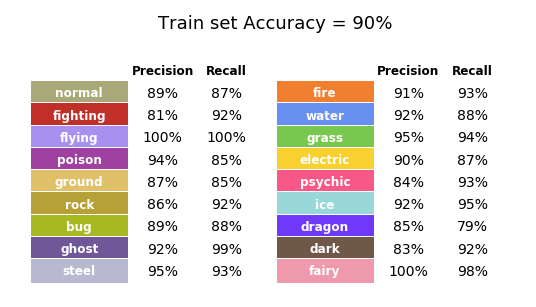

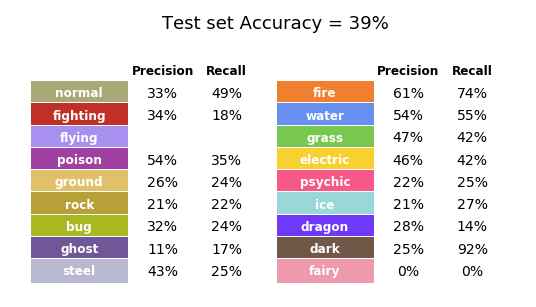

In [46]:
model.load_weights("./models/model_02.hdf5")

#Predicting values for test and train for model evaluation
pred_test = model.predict(x_test)
pred_train = model.predict(x_train)

#Computing metrics for train
plot_evaluation("Train set",y_train,pred_train)

#Computing metrics for test
plot_evaluation("Test set",y_test,pred_test)

Finally we plot all the predictions over the test set for the fifth generation, separating the sprites over the correct and wrong classifications.

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


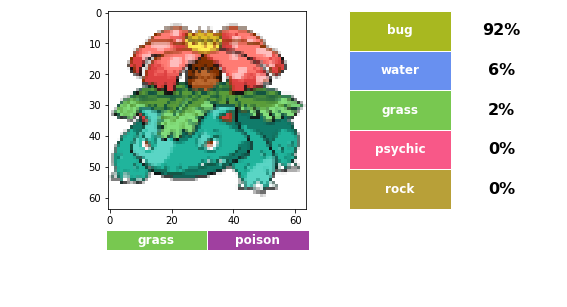

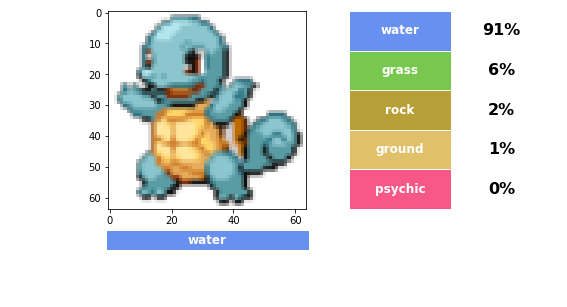

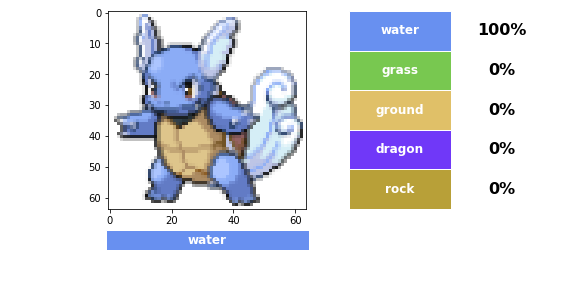

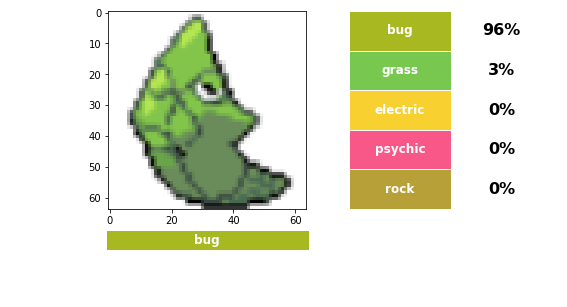

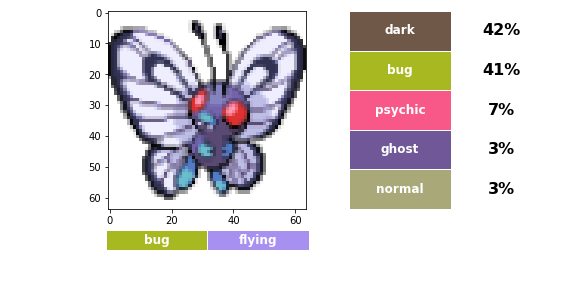

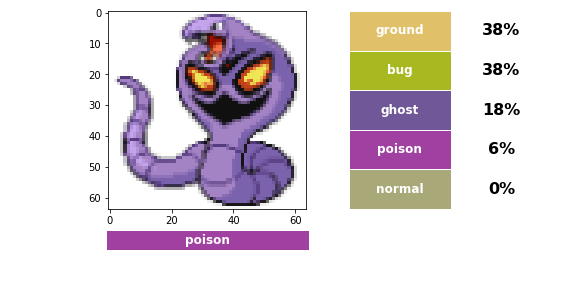

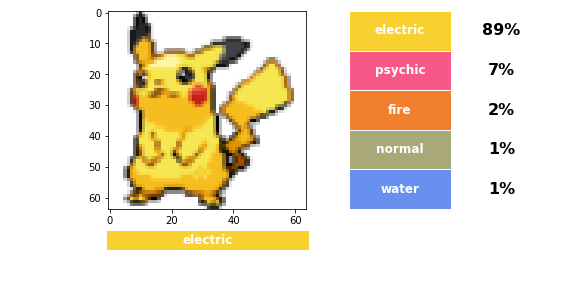

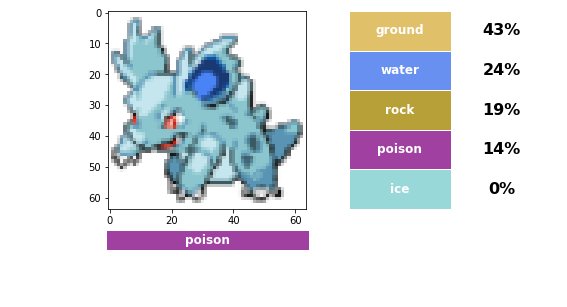

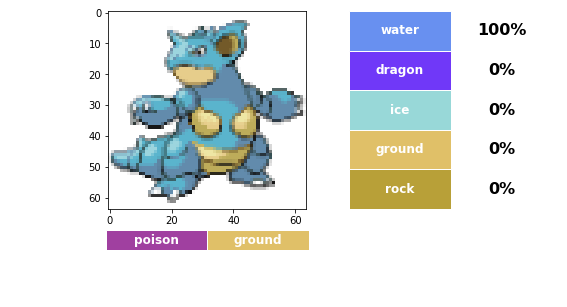

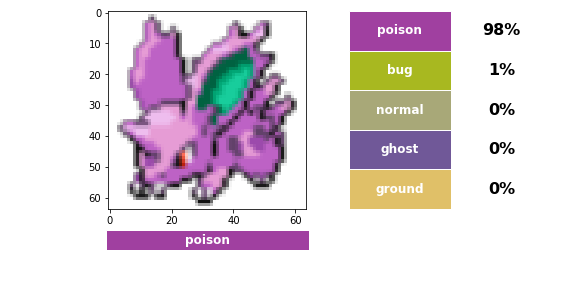

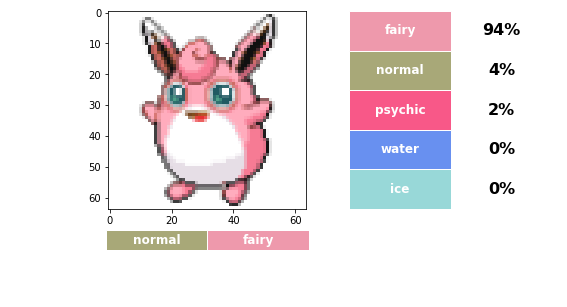

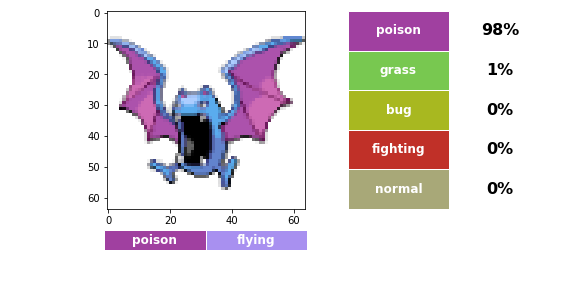

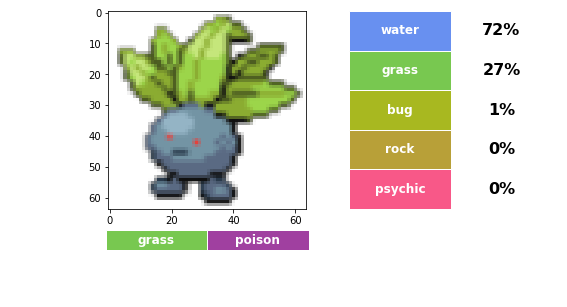

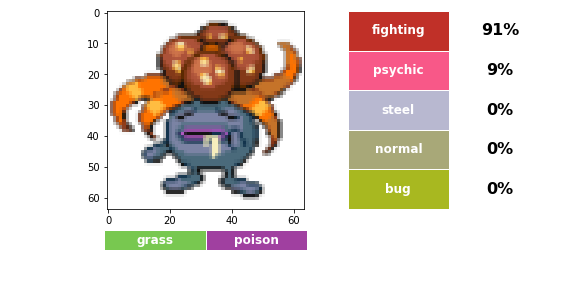

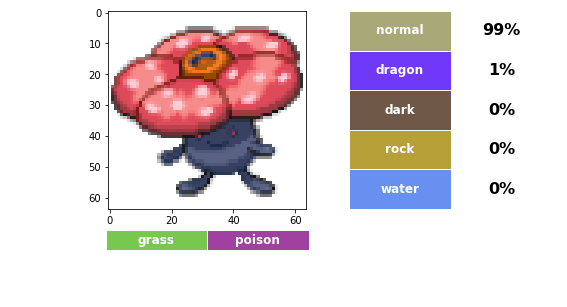

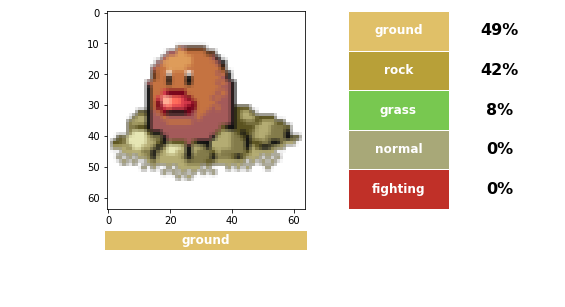

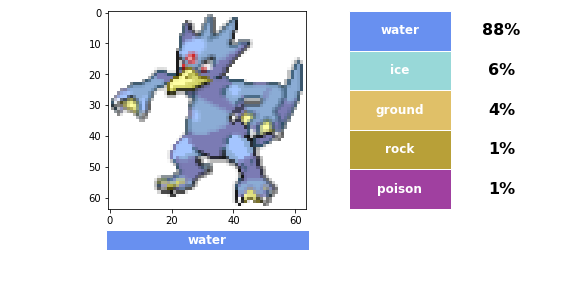

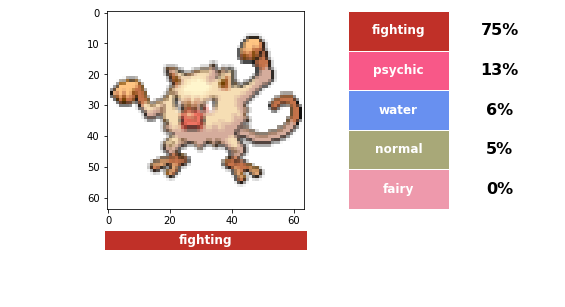

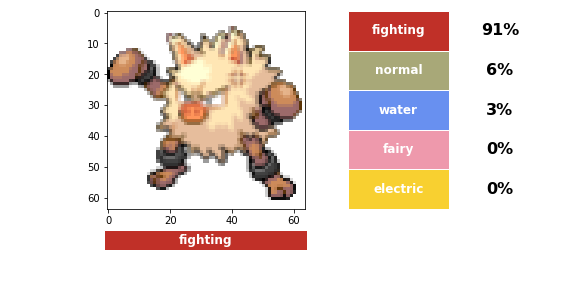

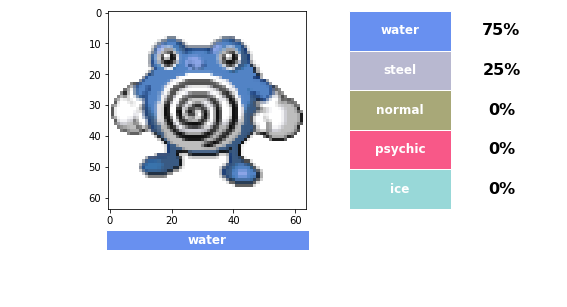

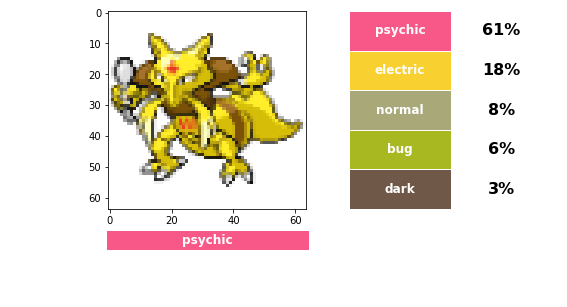

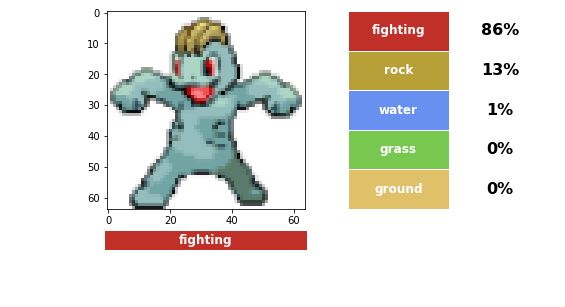

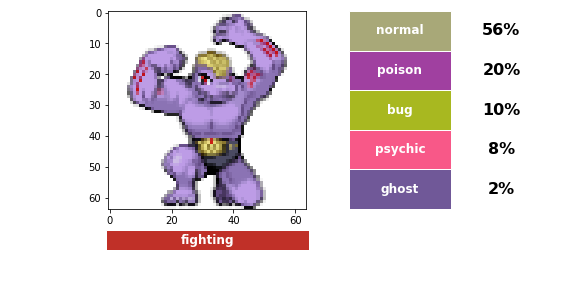

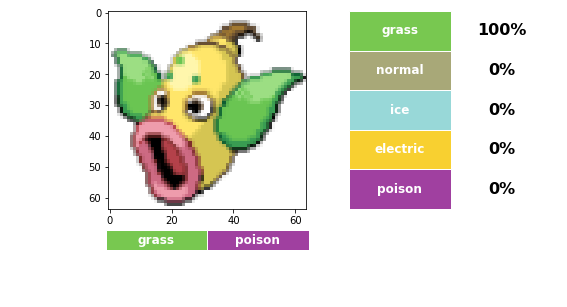

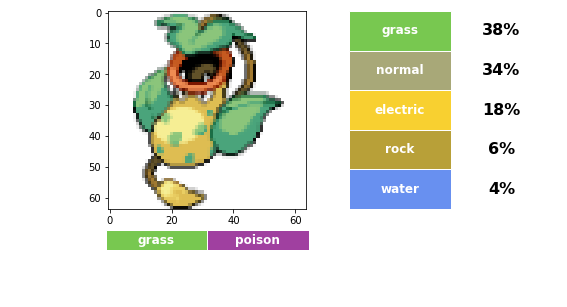

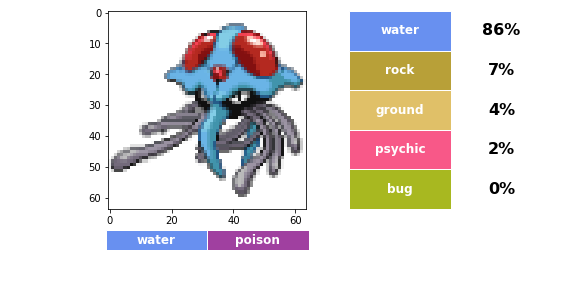

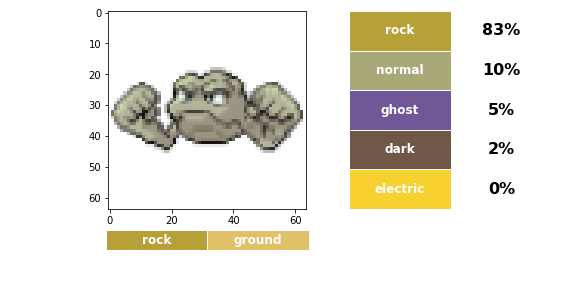

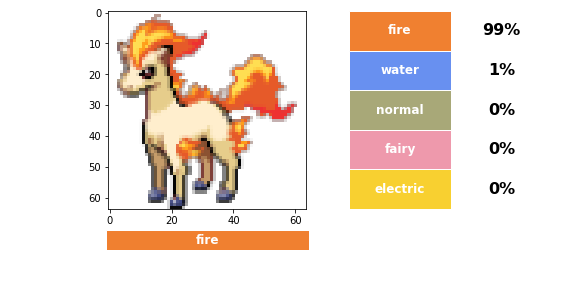

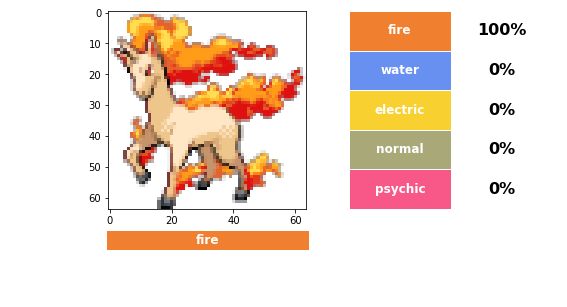

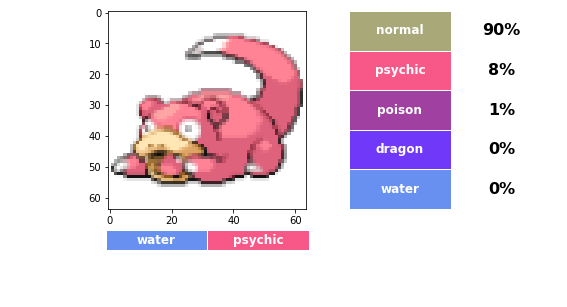

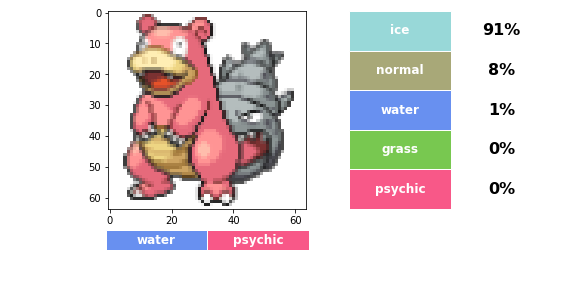

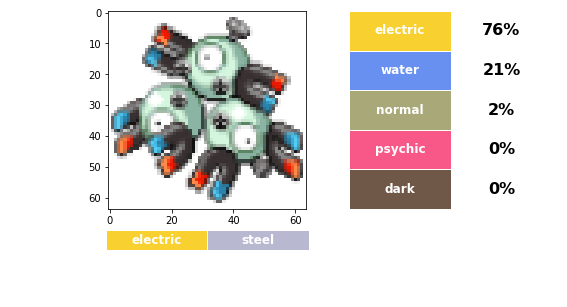

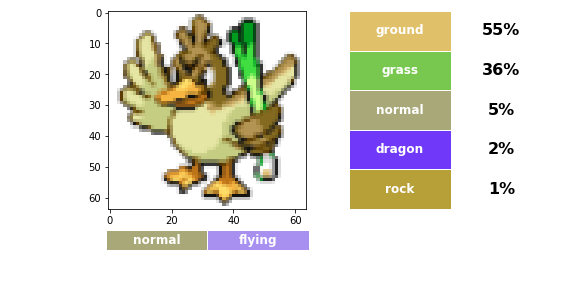

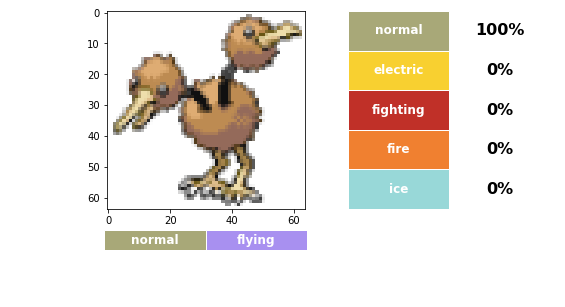

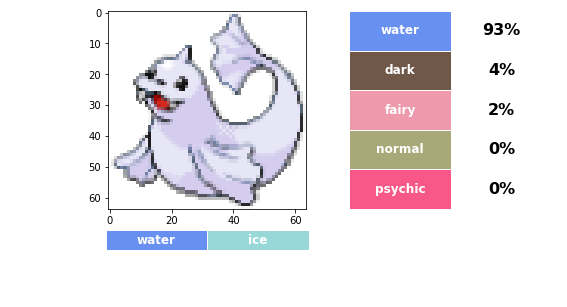

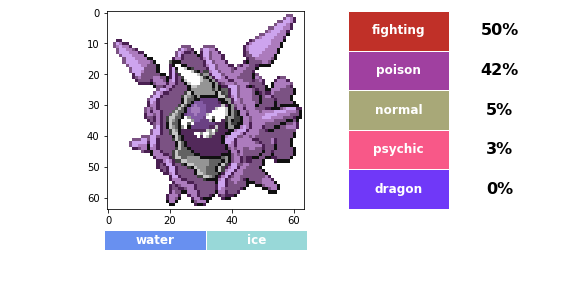

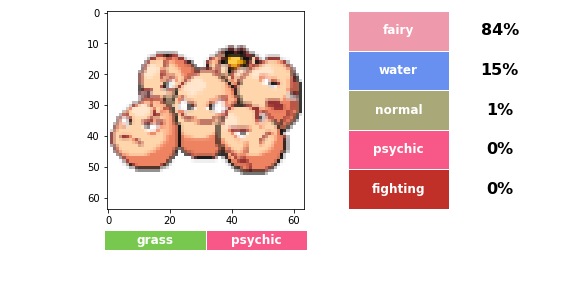

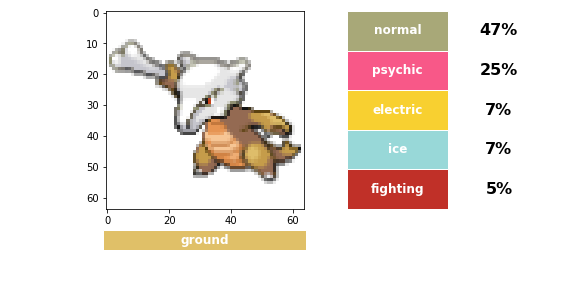

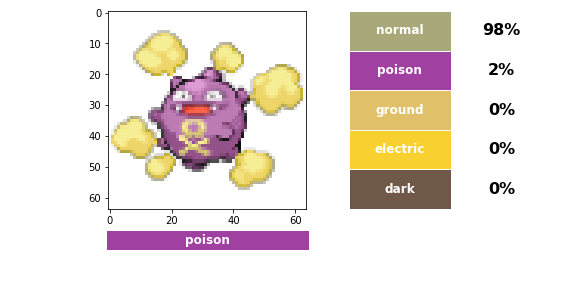

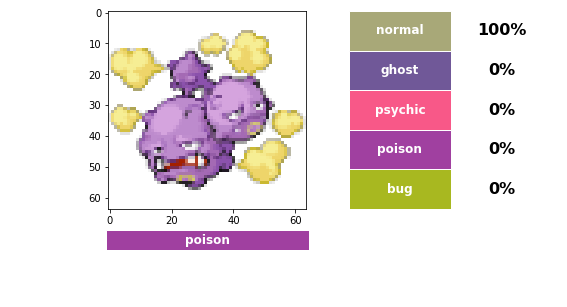

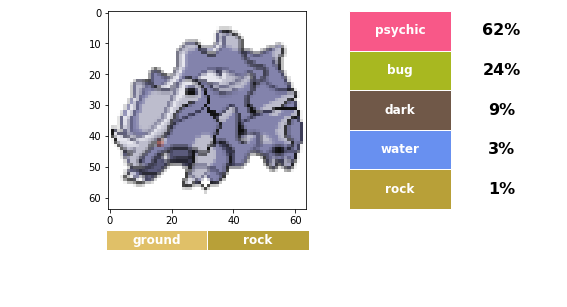

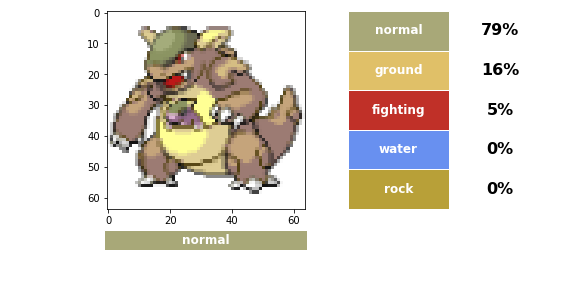

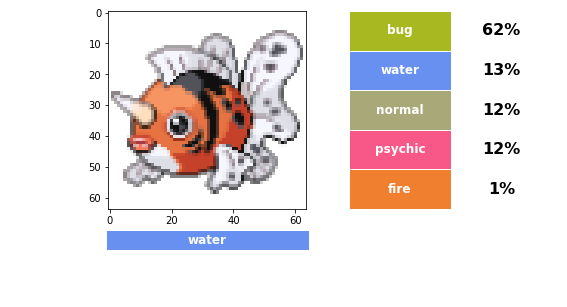

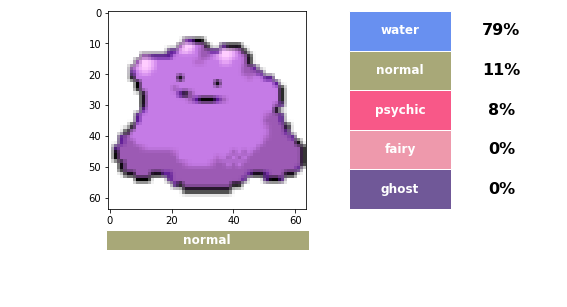

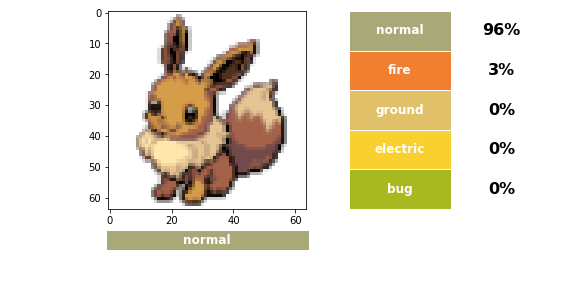

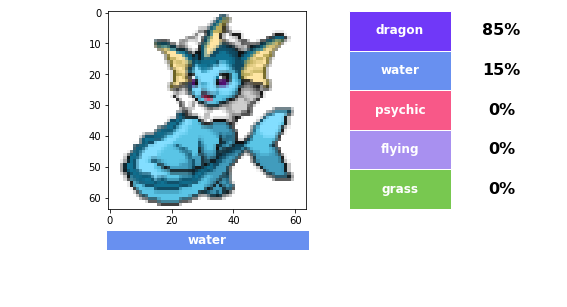

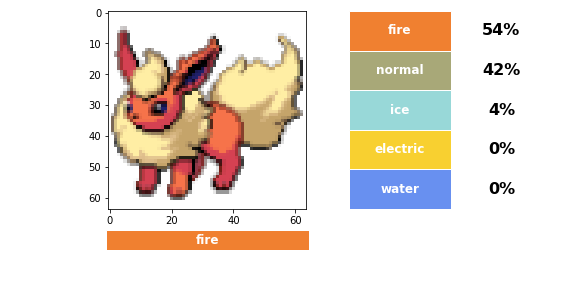

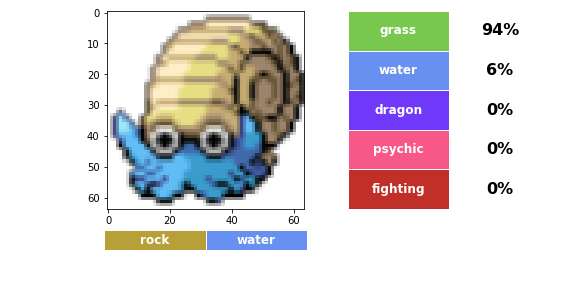

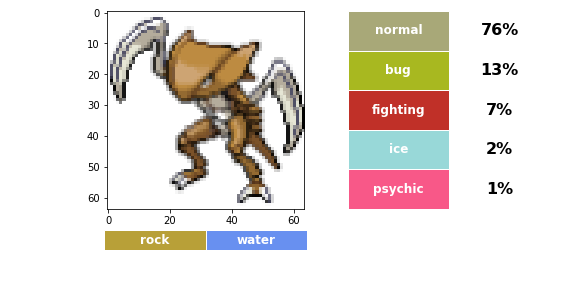

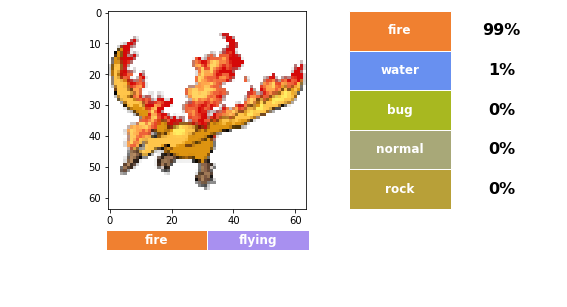

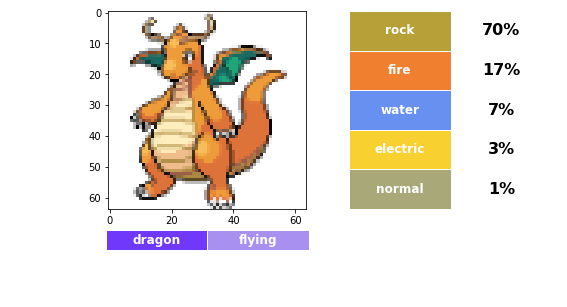

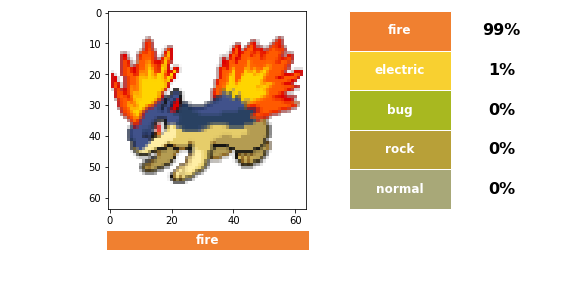

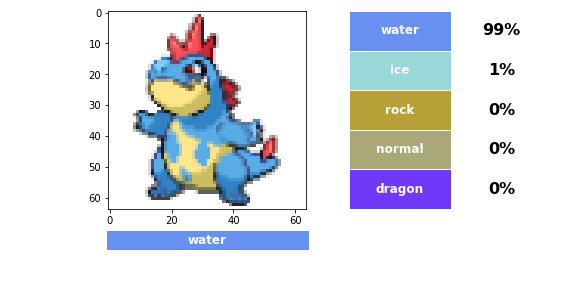

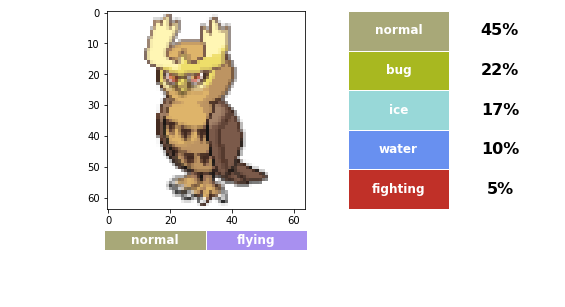

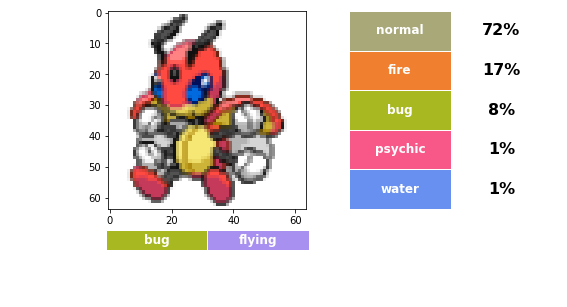

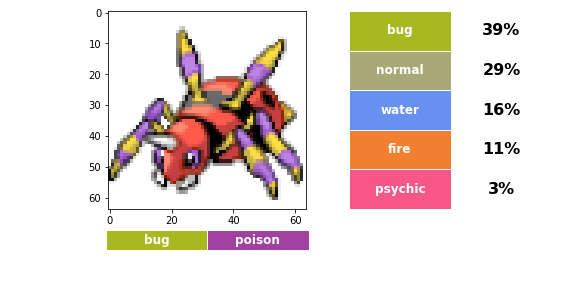

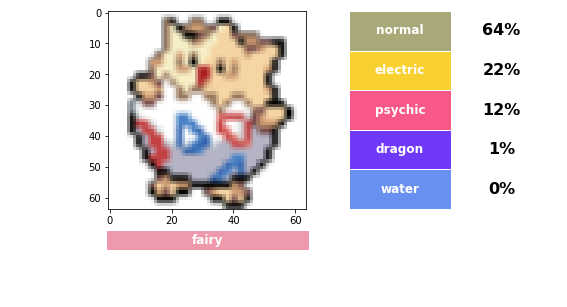

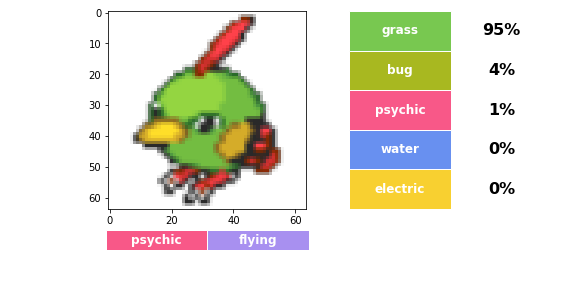

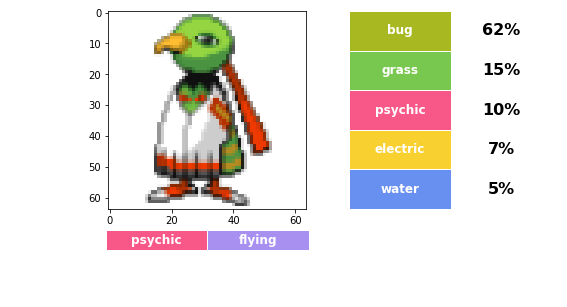

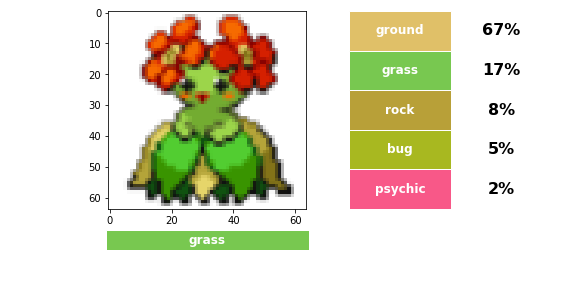

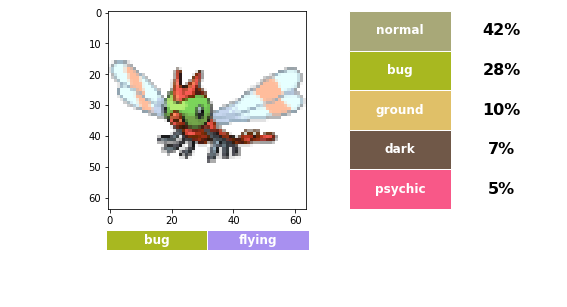

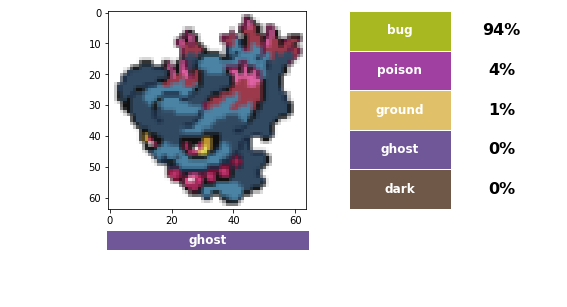

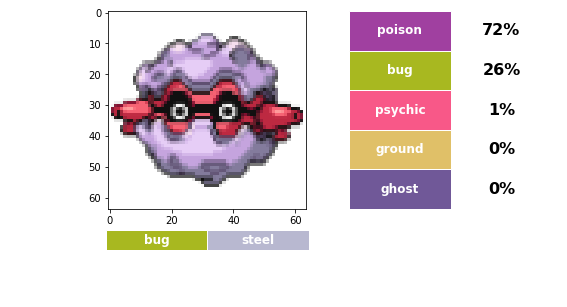

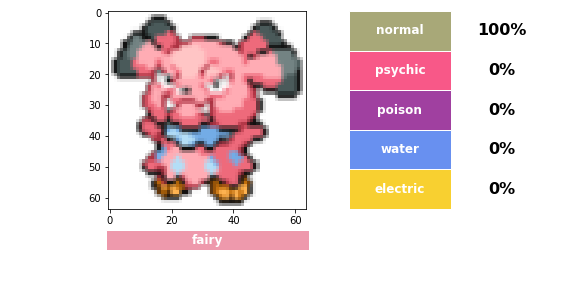

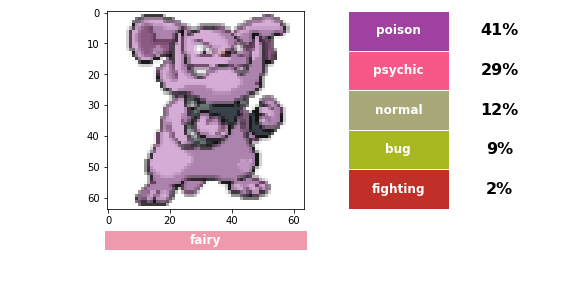

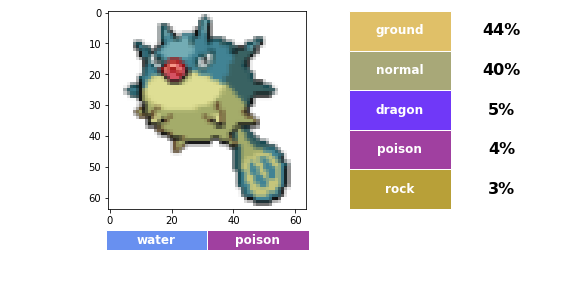

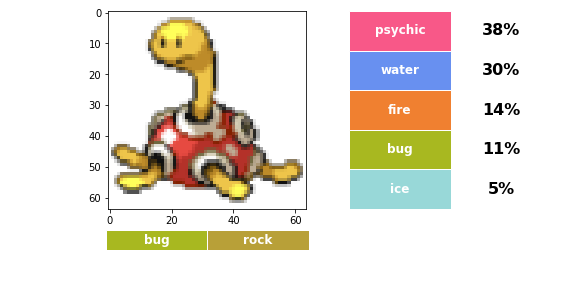

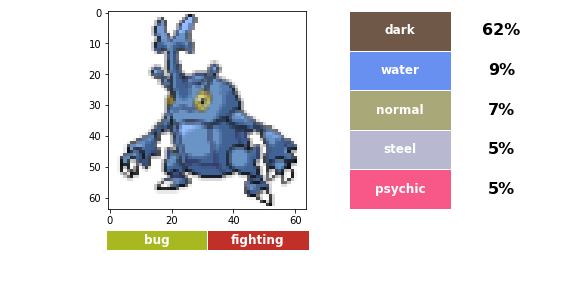

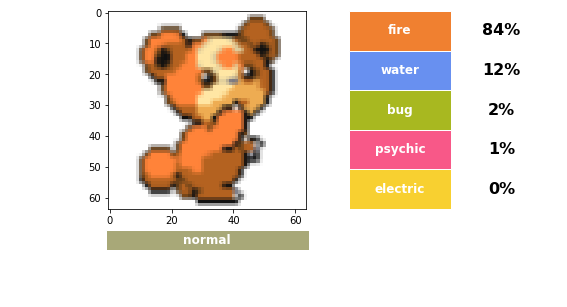

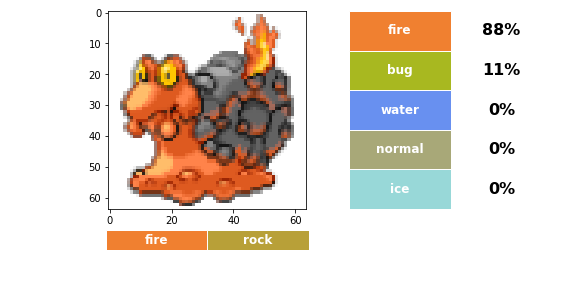

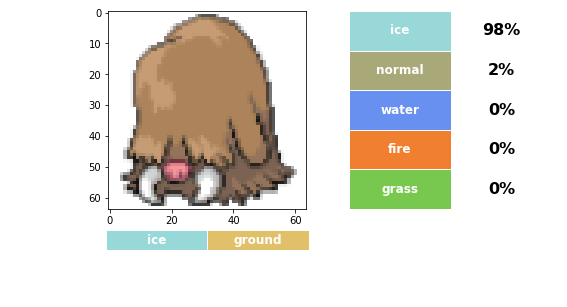

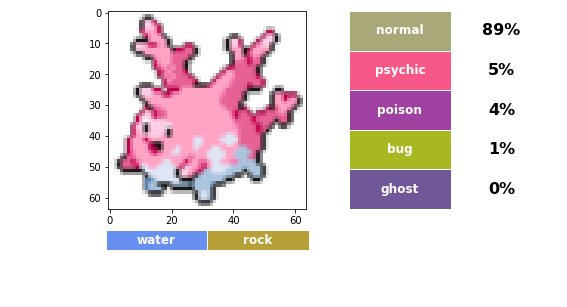

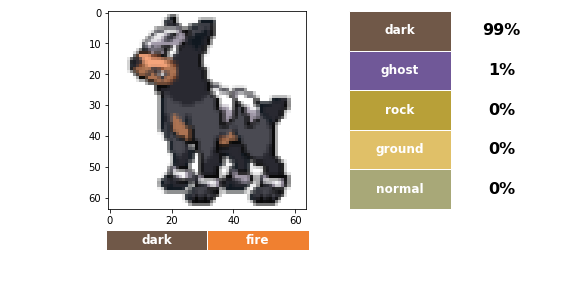

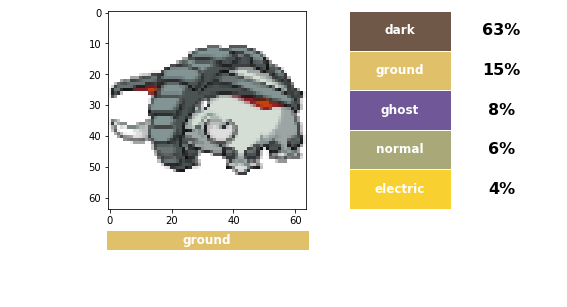

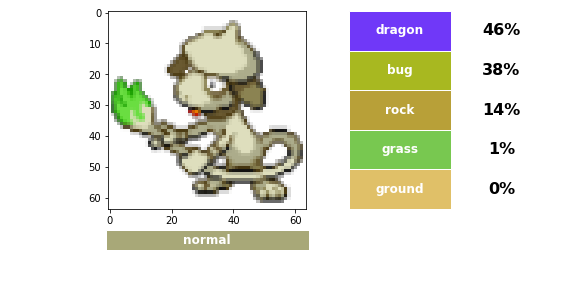

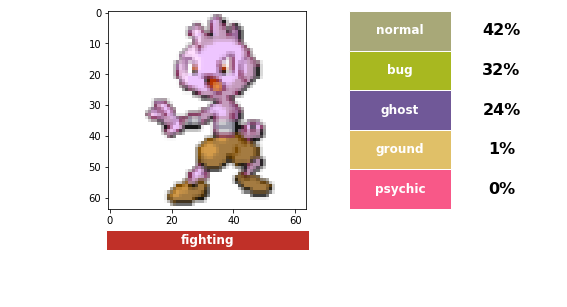

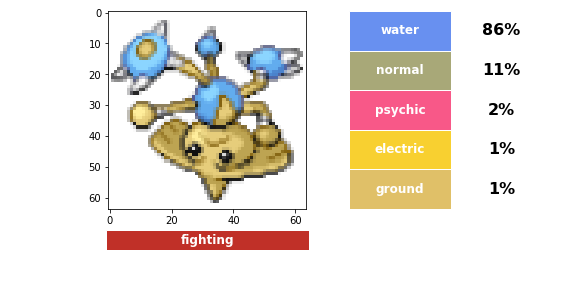

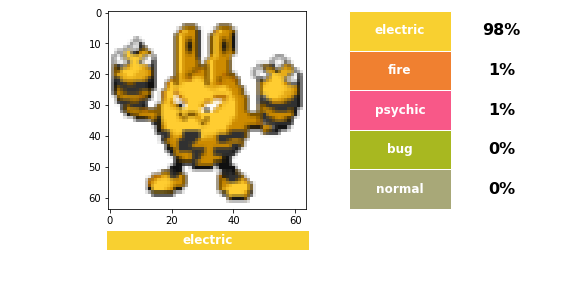

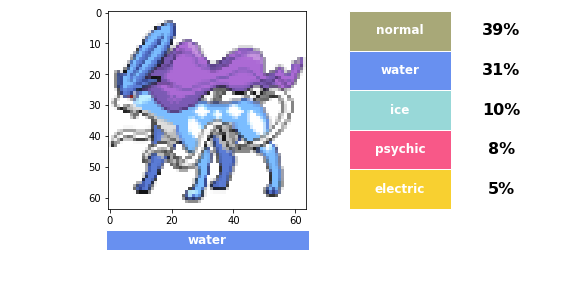

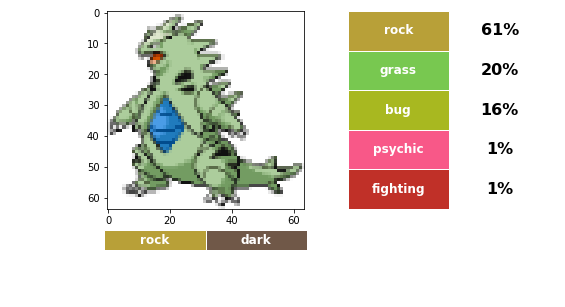

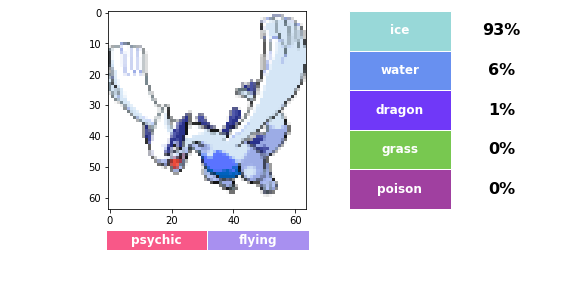

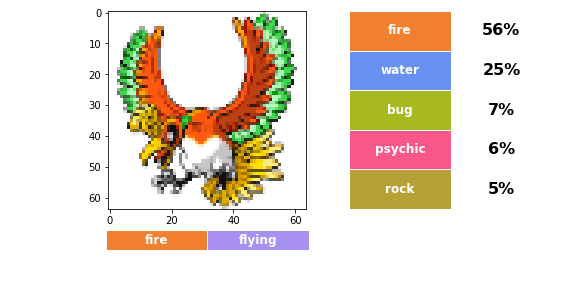

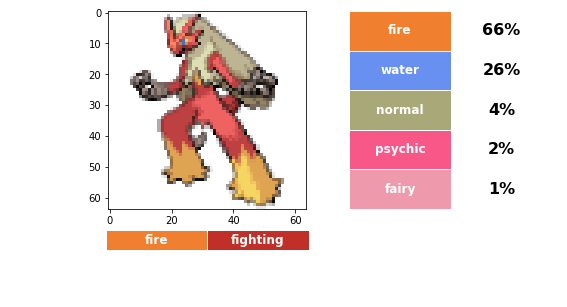

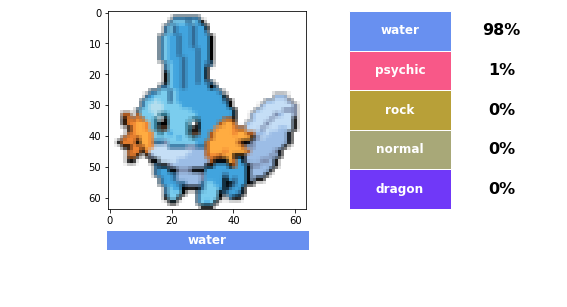

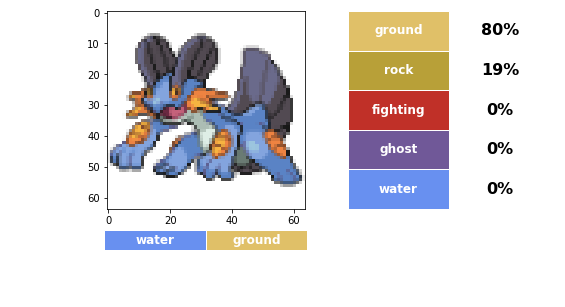

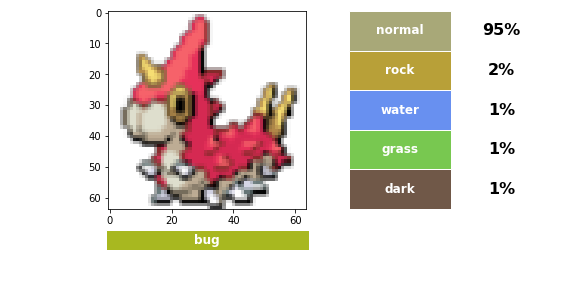

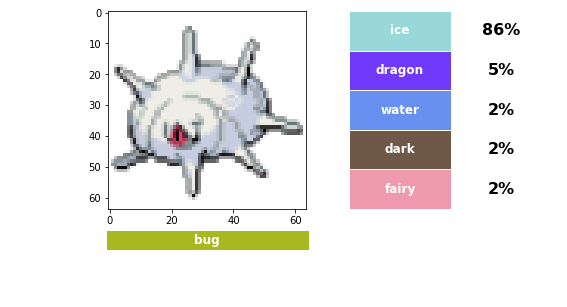

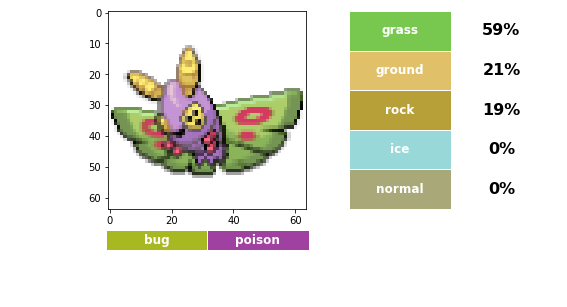

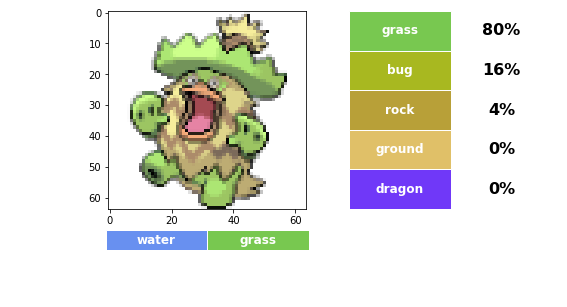

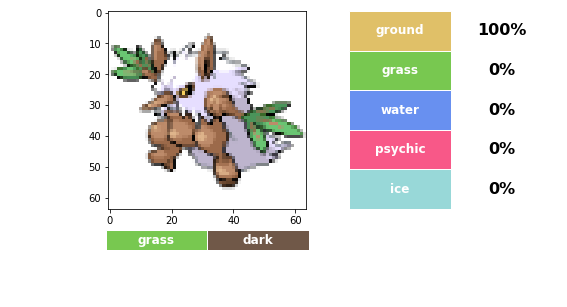

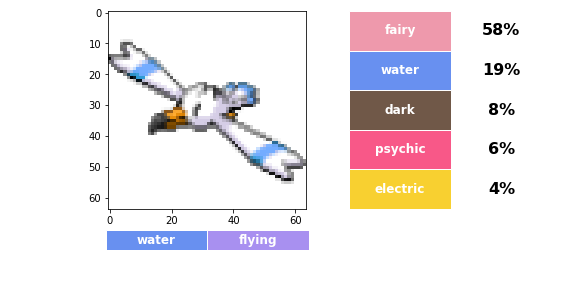

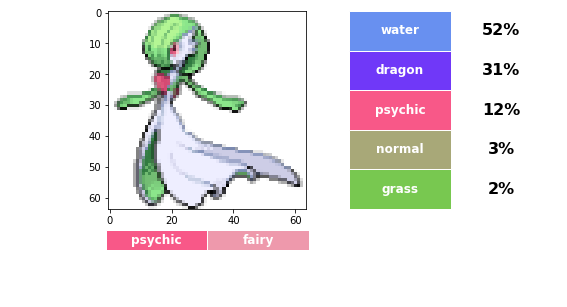

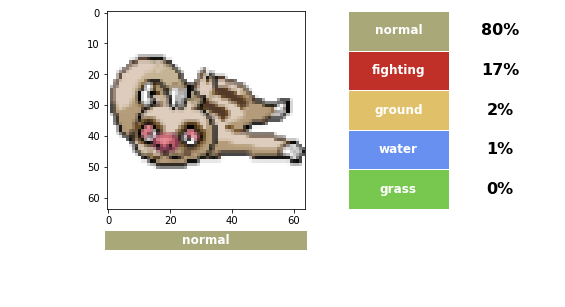

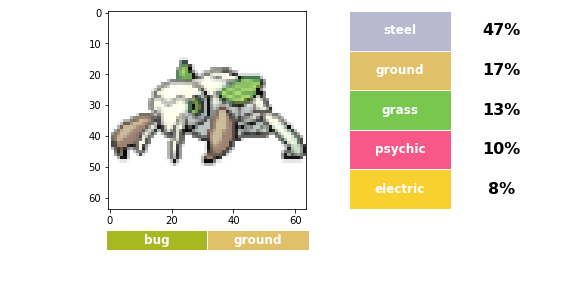

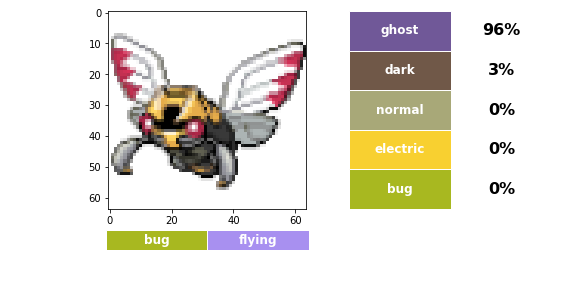

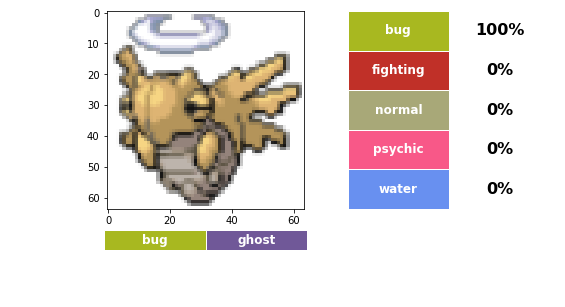

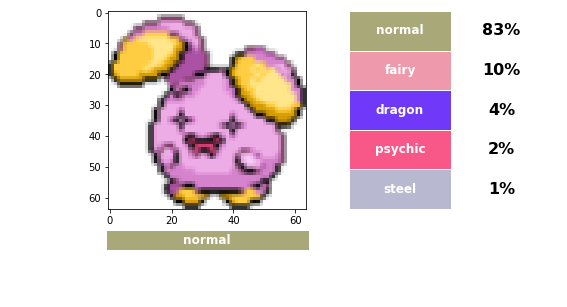

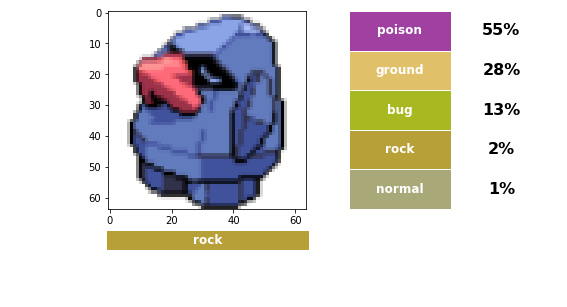

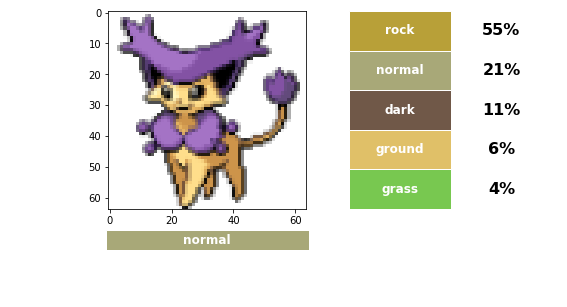

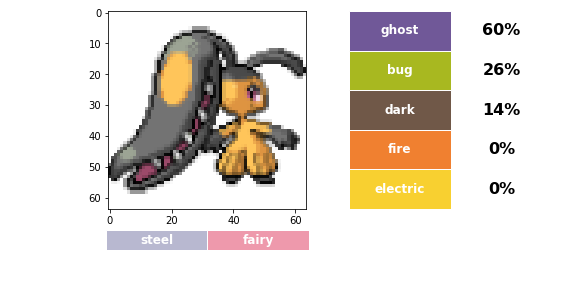

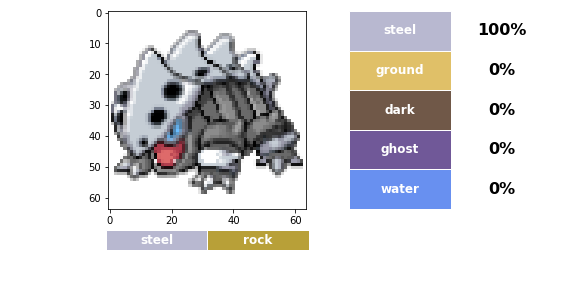

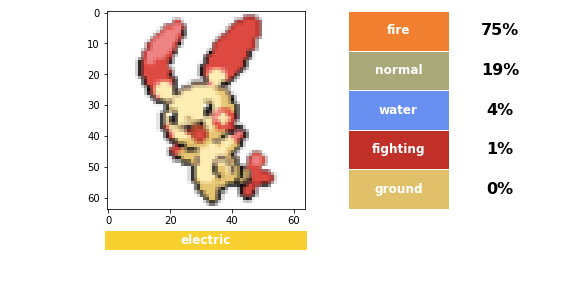

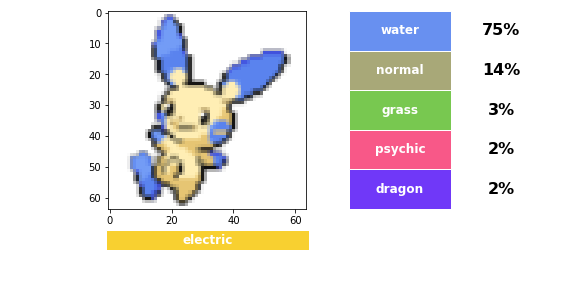

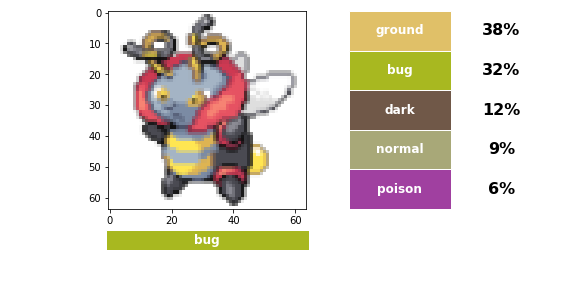

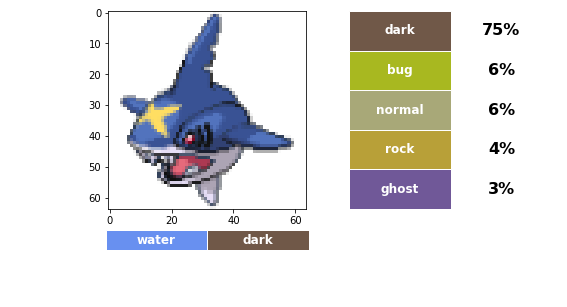

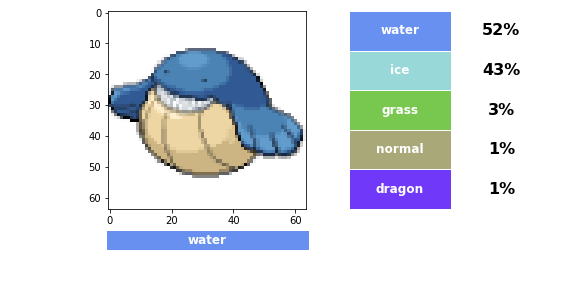

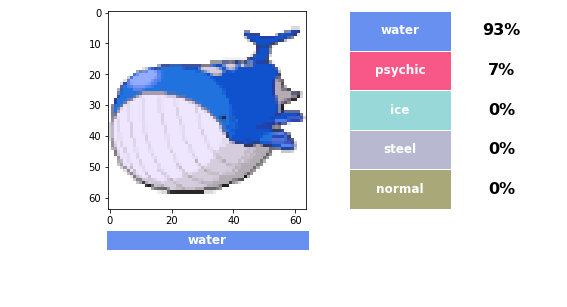

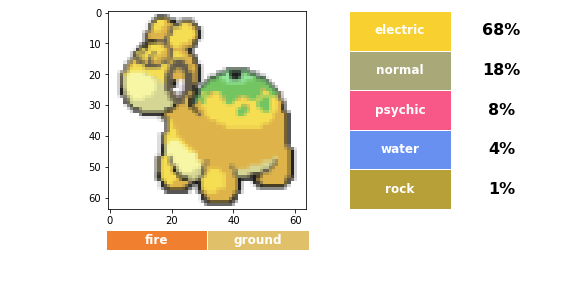

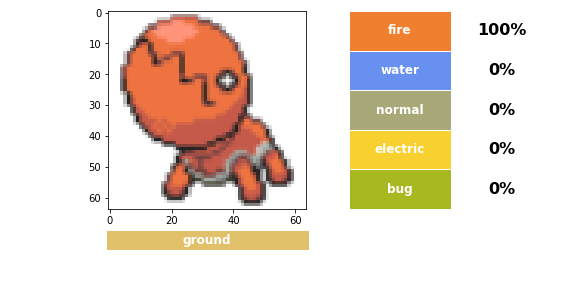

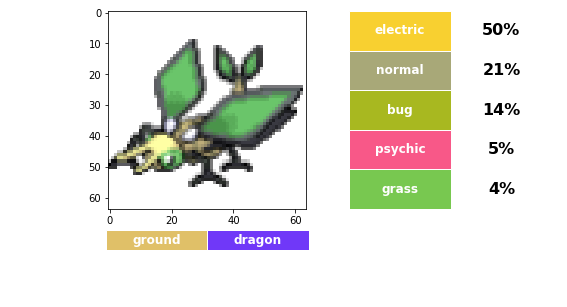

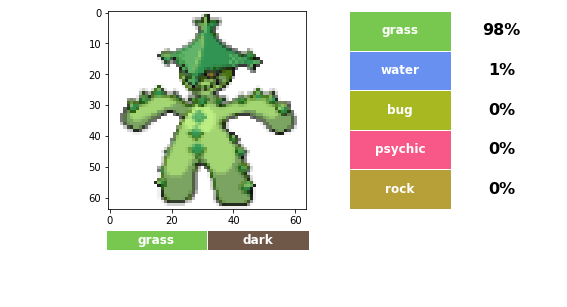

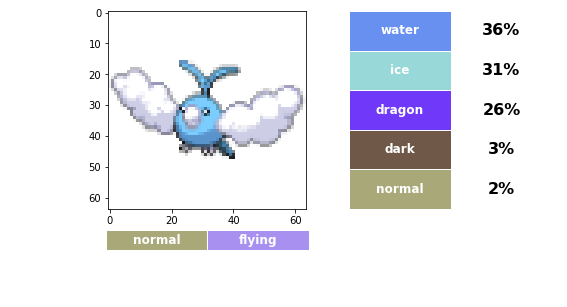

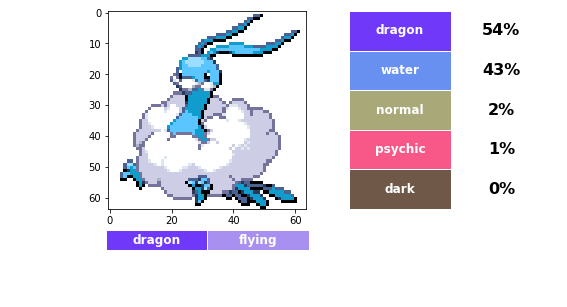

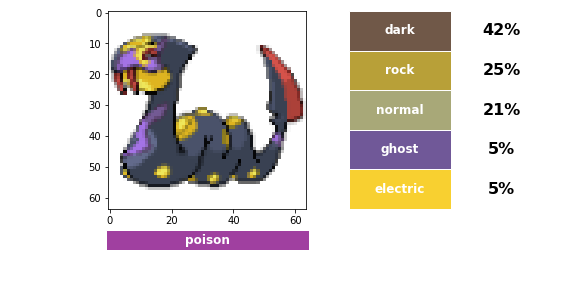

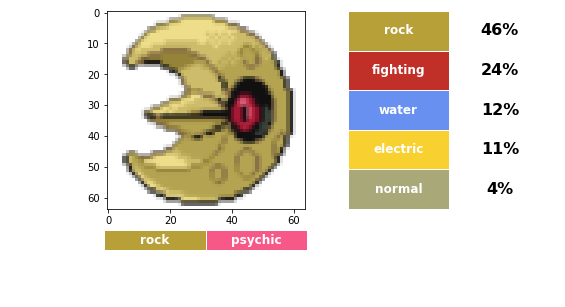

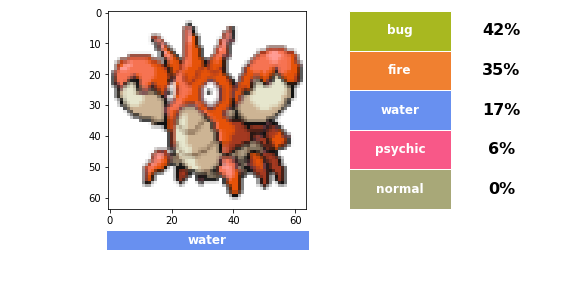

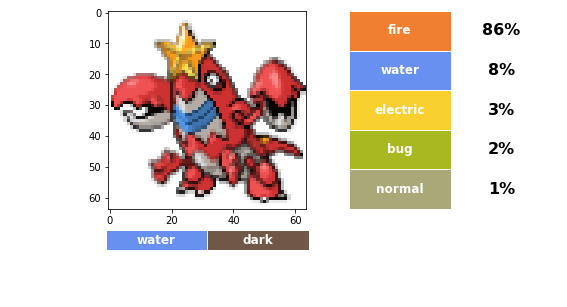

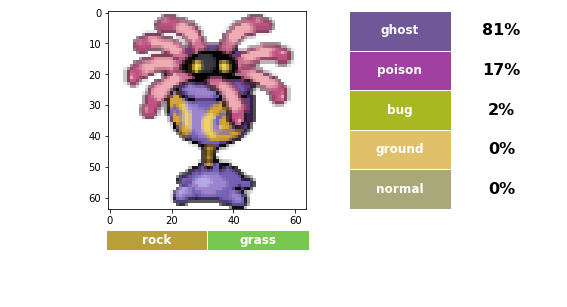

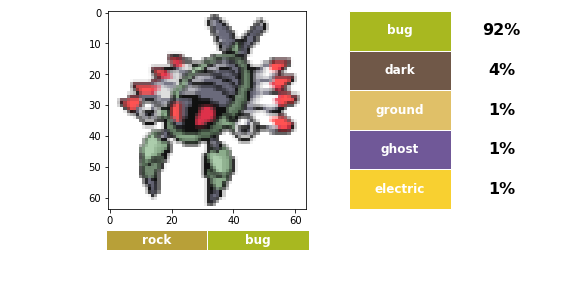

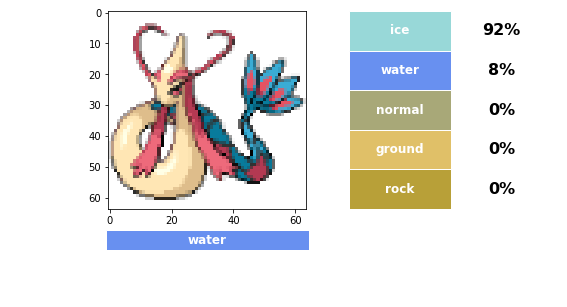

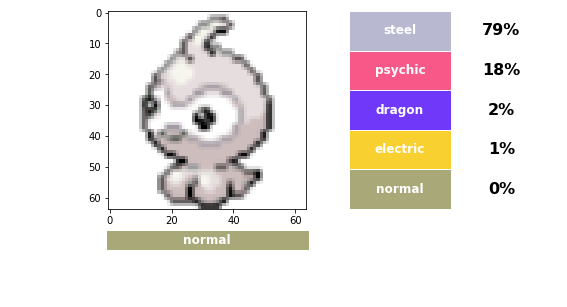

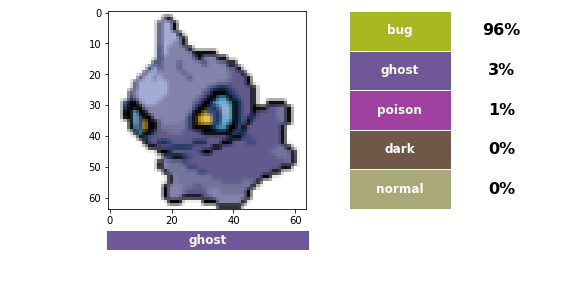

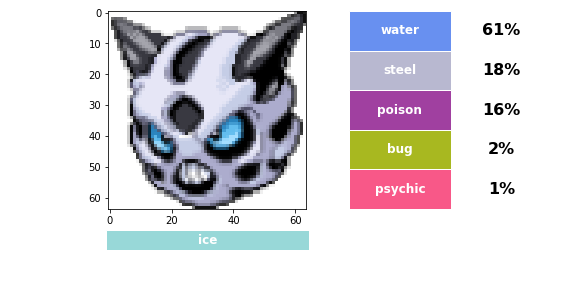

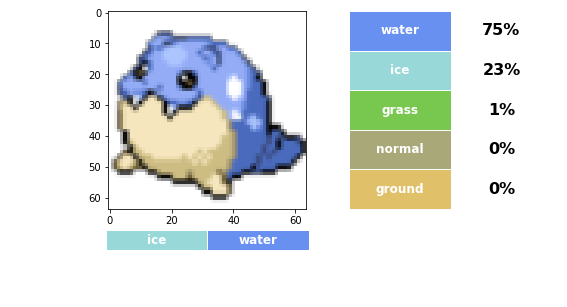

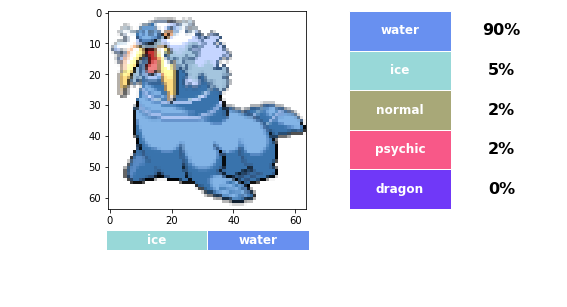

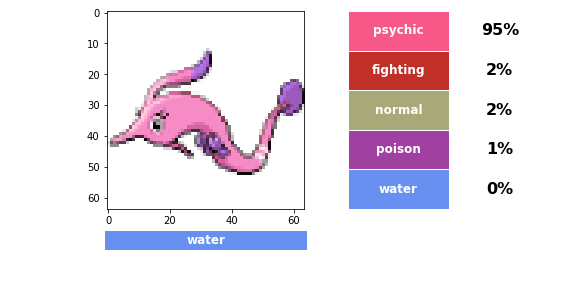

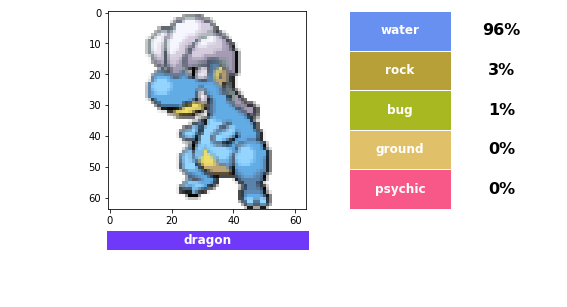

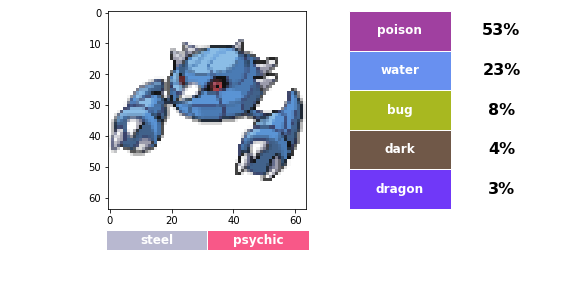

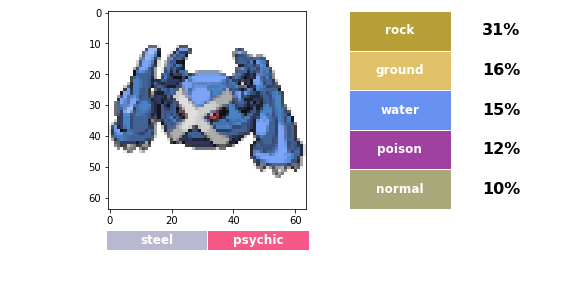

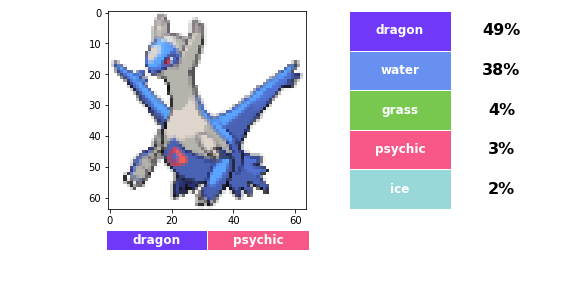

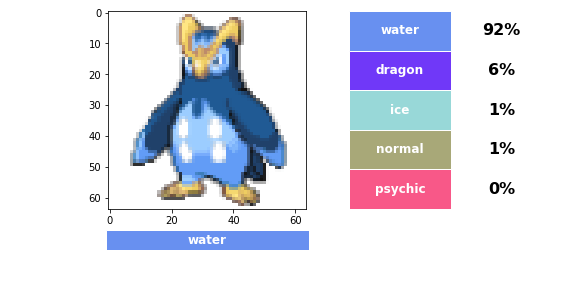

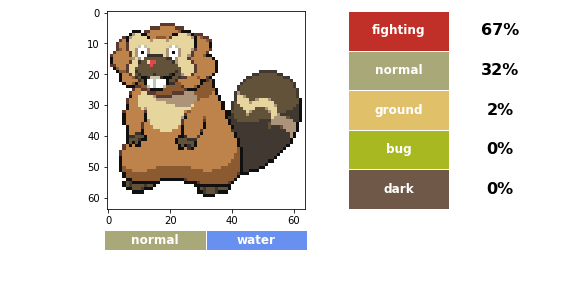

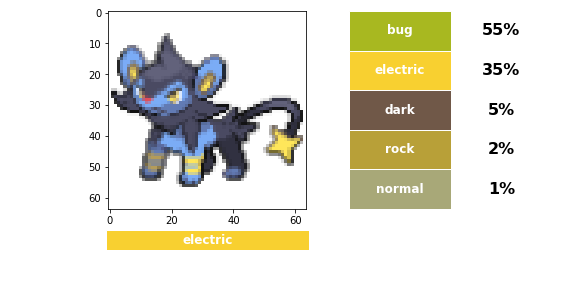

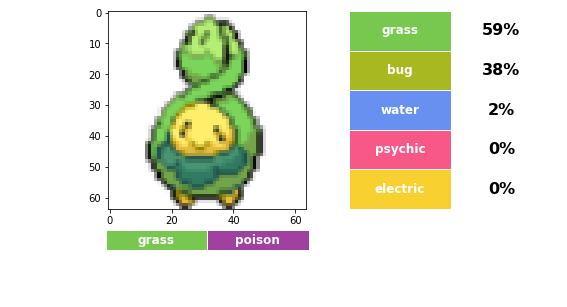

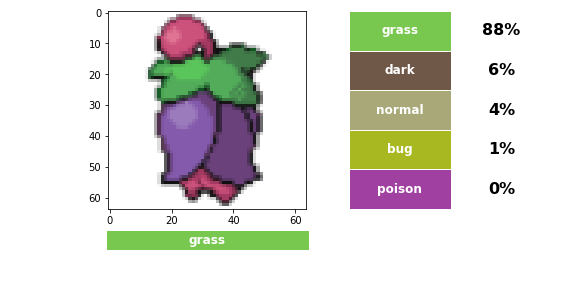

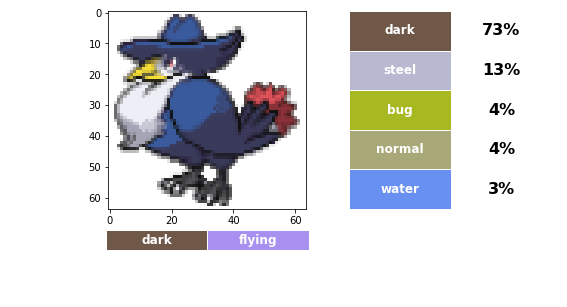

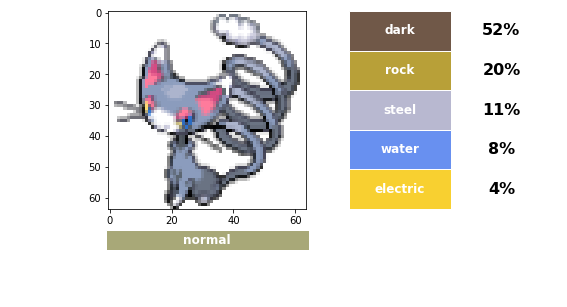

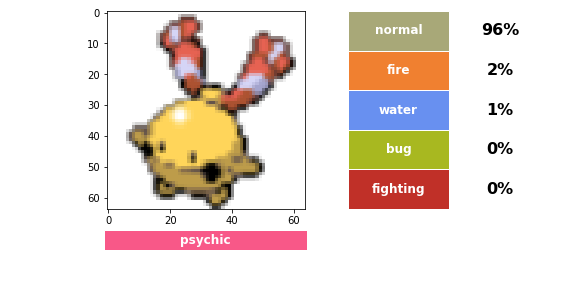

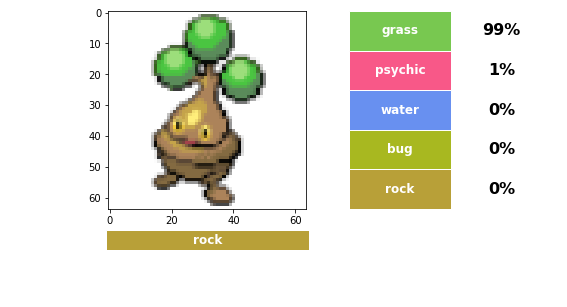

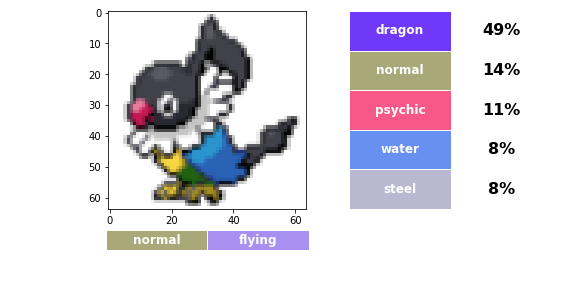

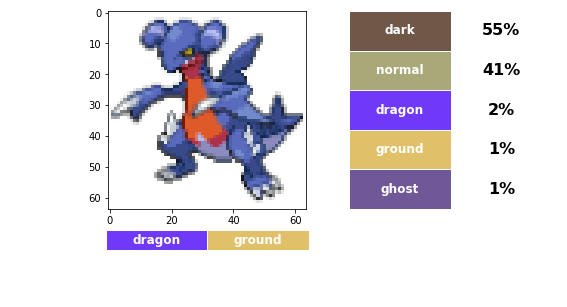

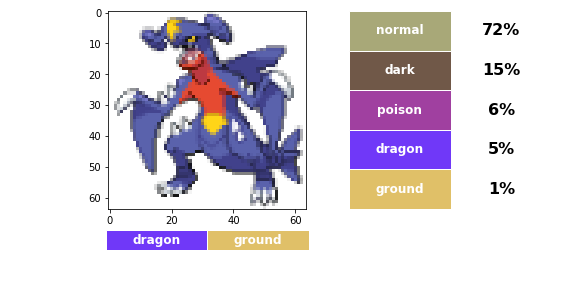

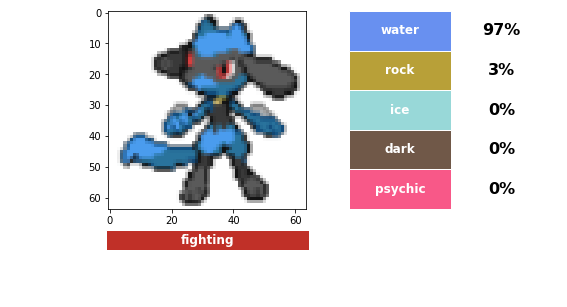

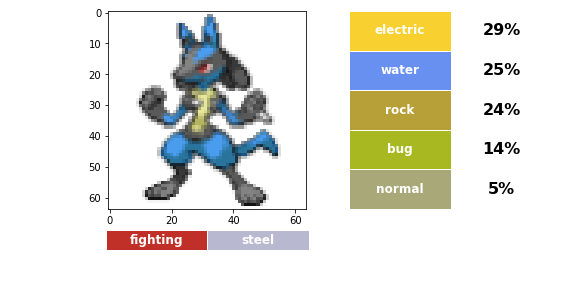

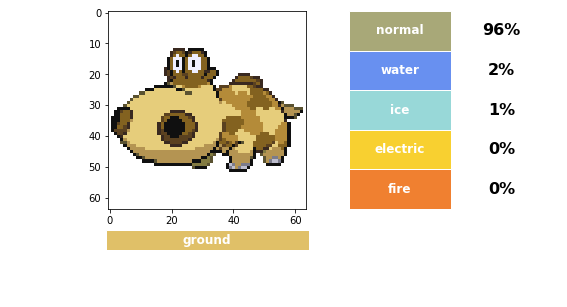

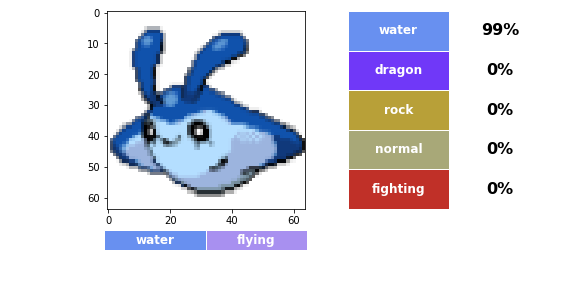

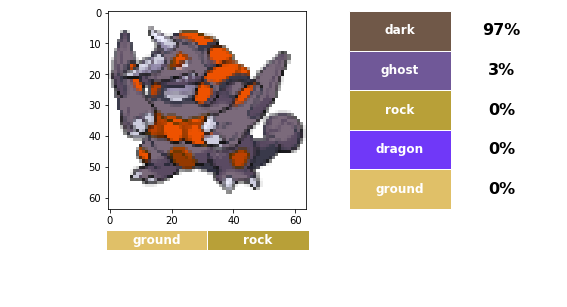

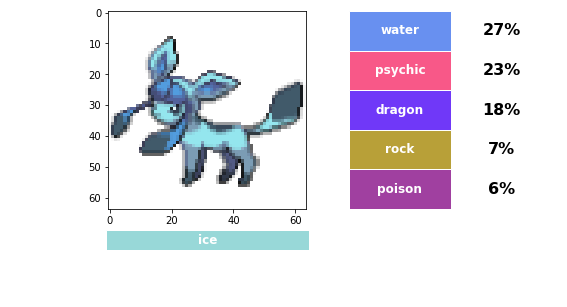

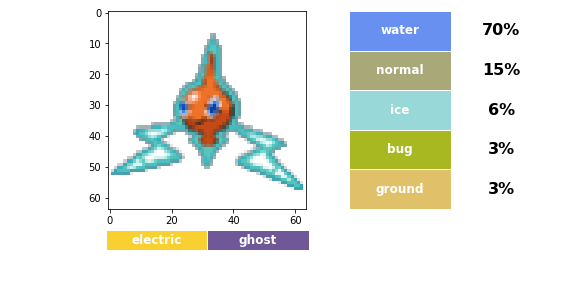

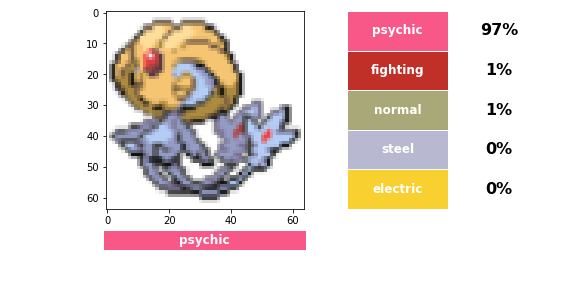

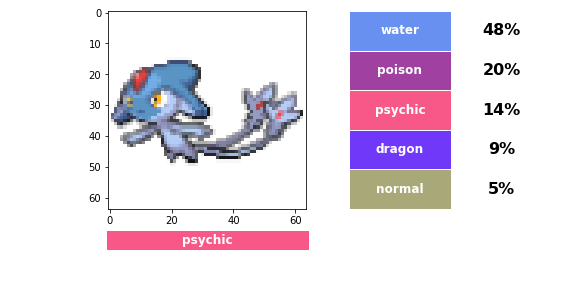

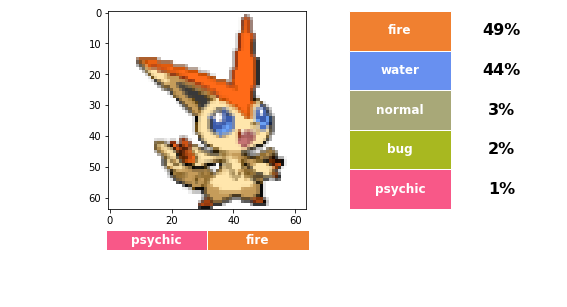

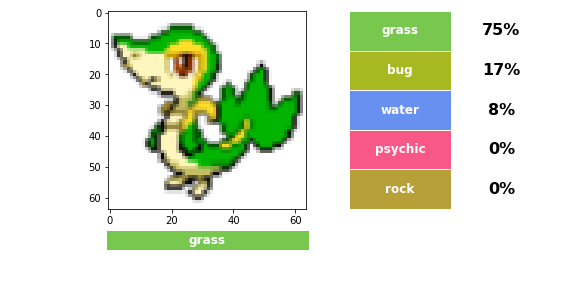

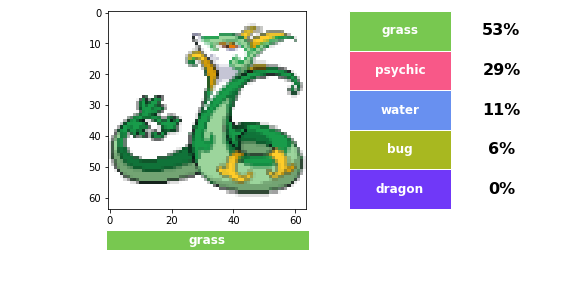

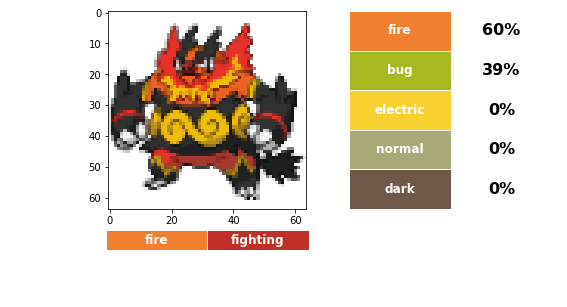

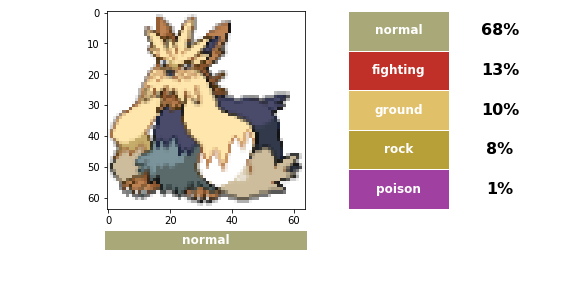

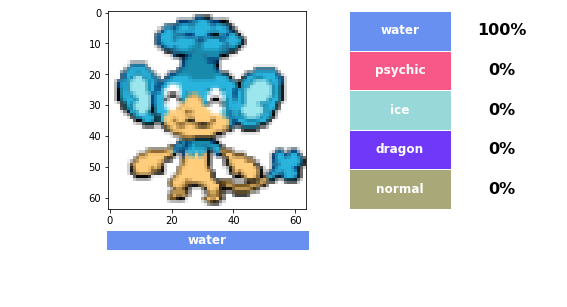

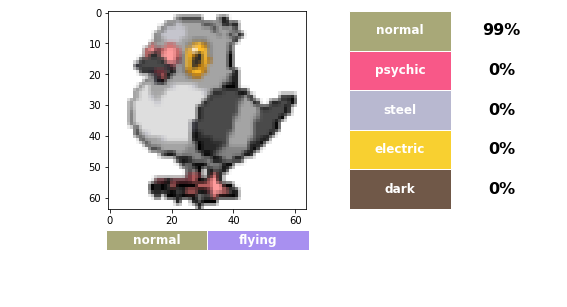

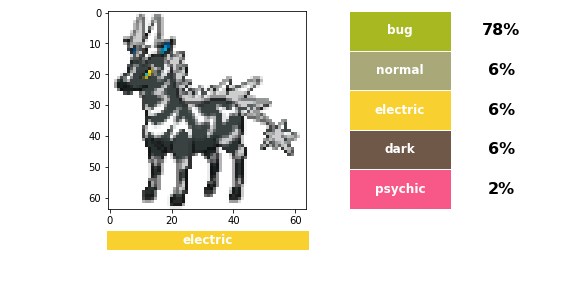

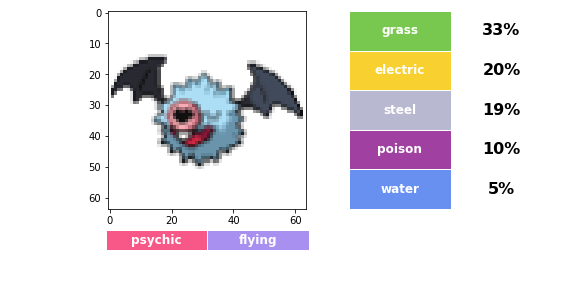

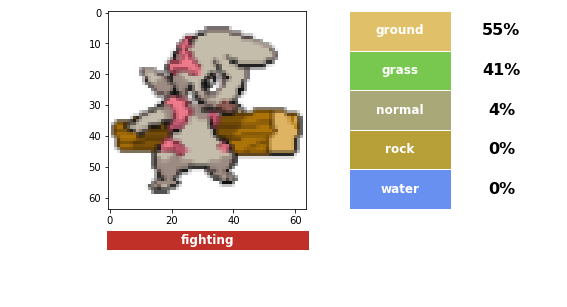

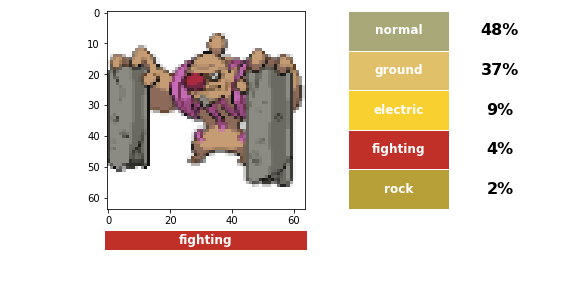

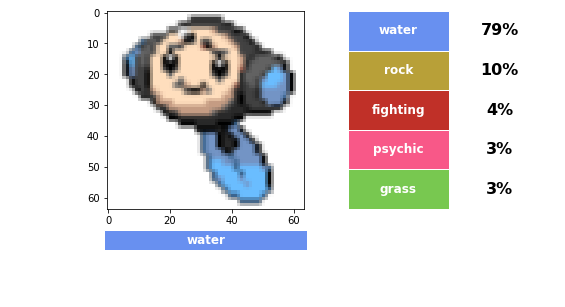

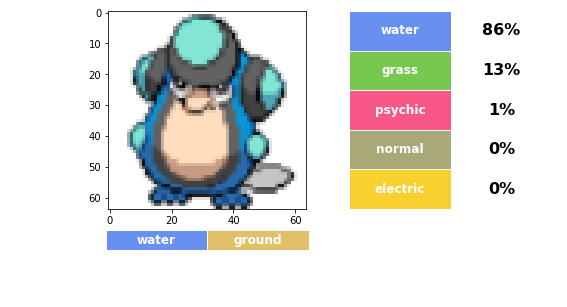

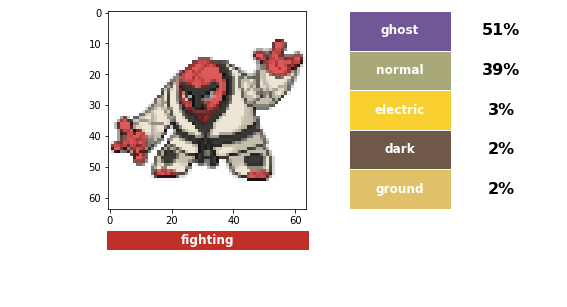

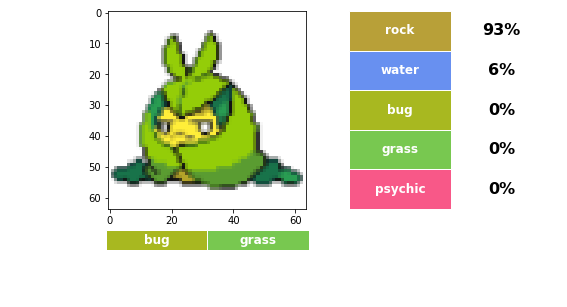

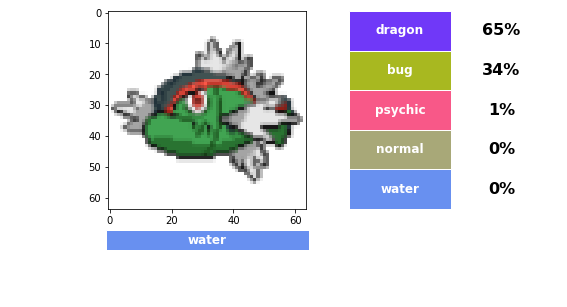

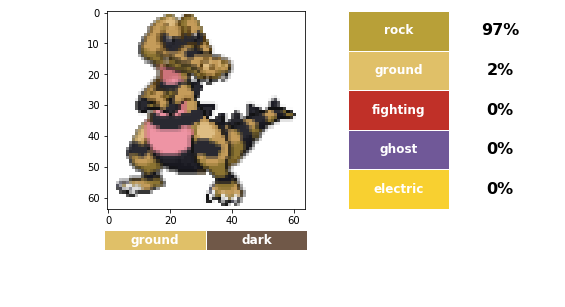

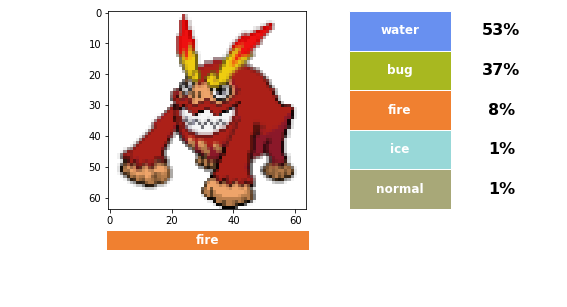

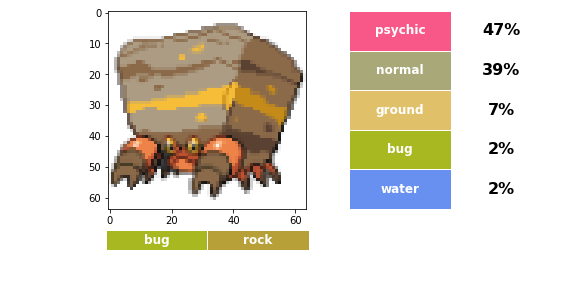

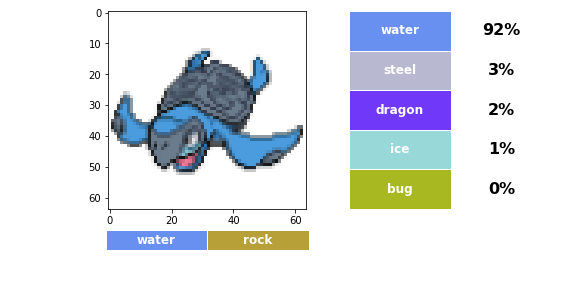

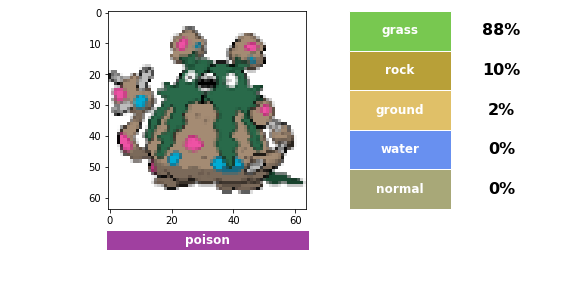

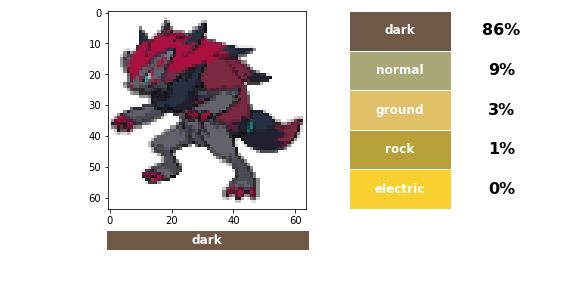

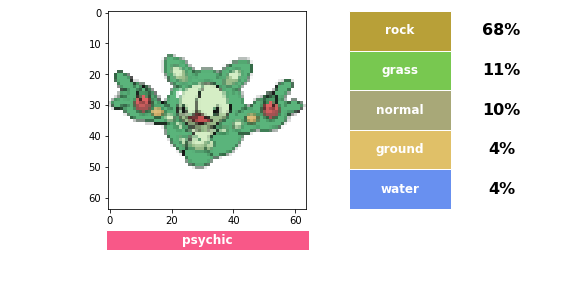

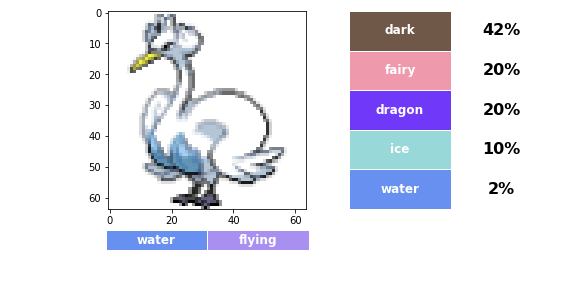

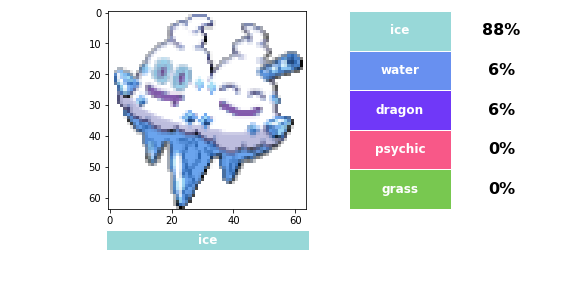

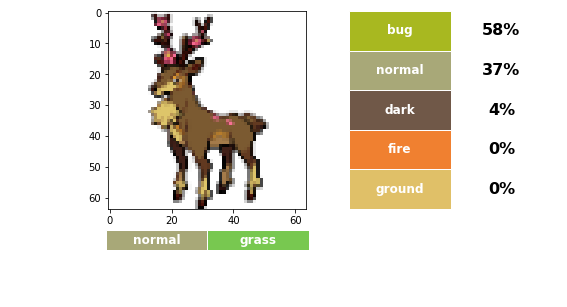

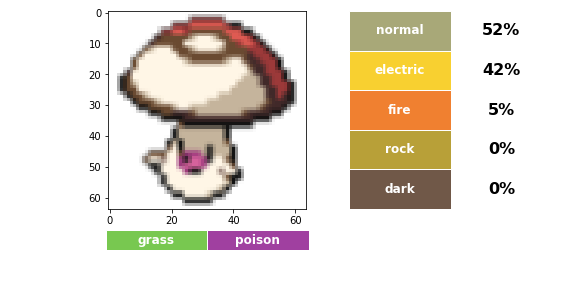

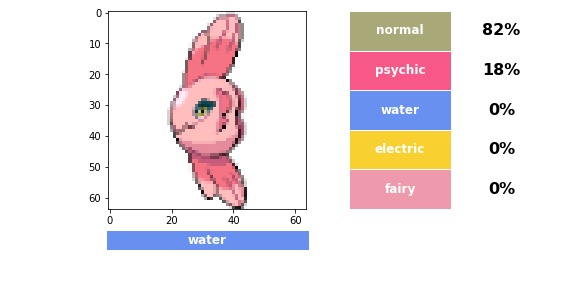

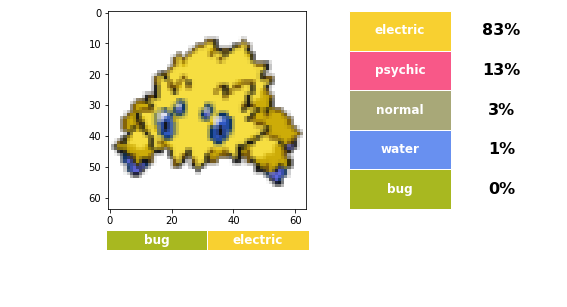

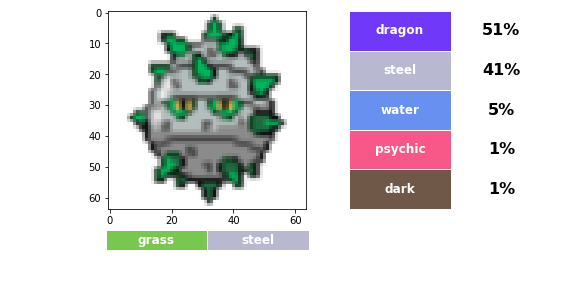

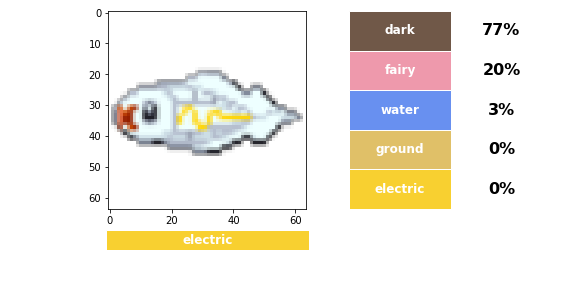

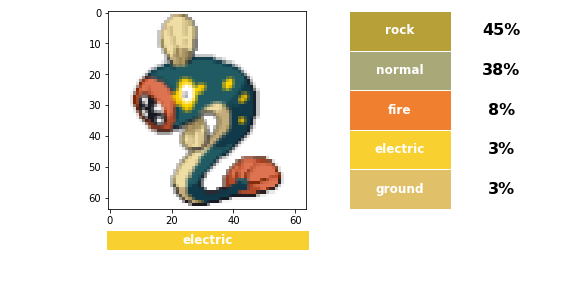

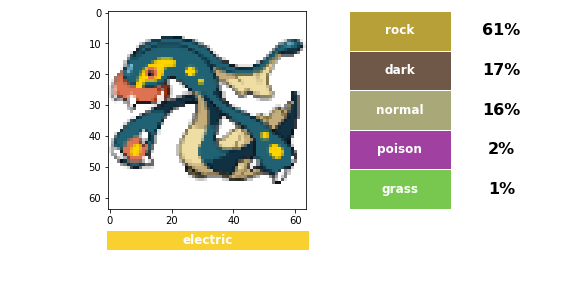

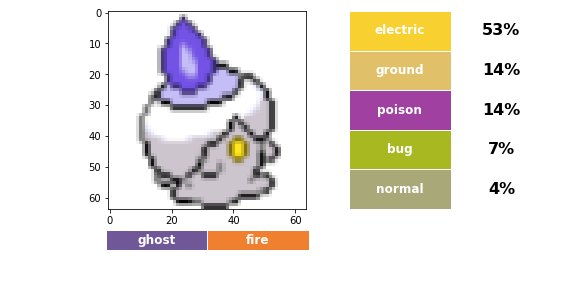

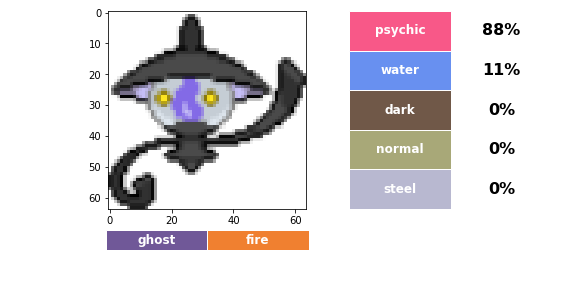

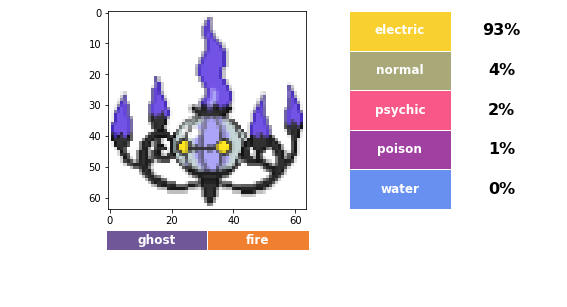

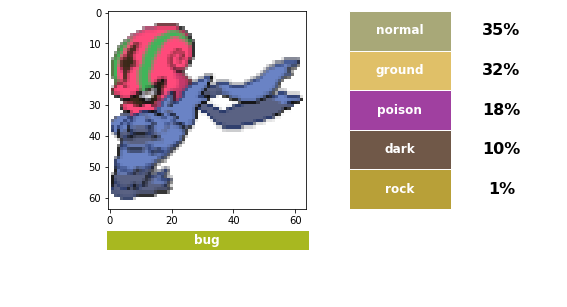

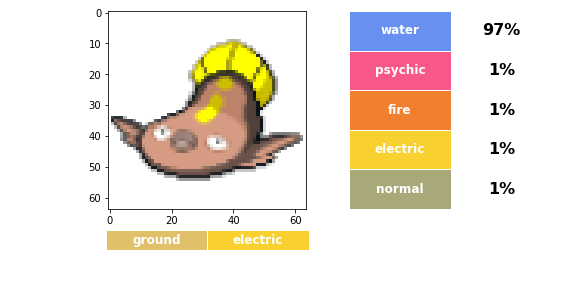

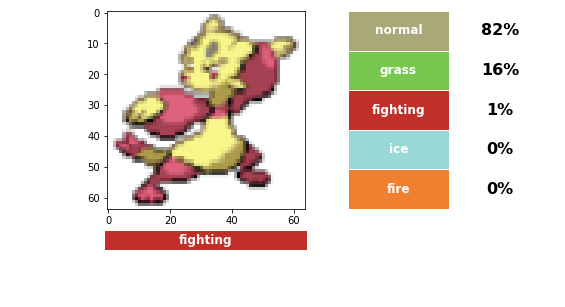

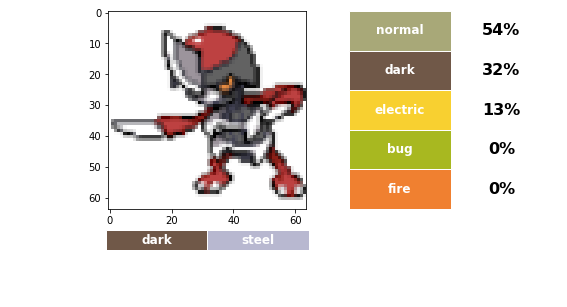

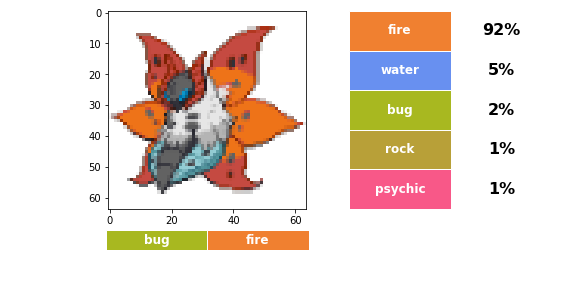

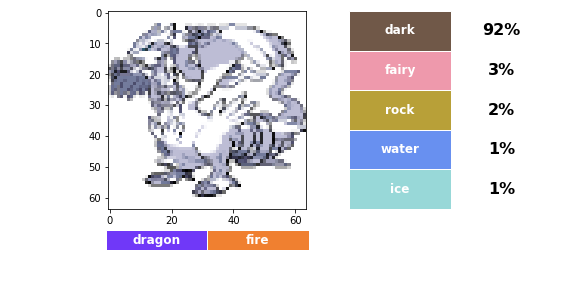

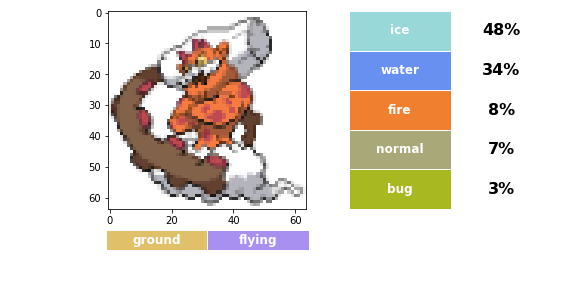

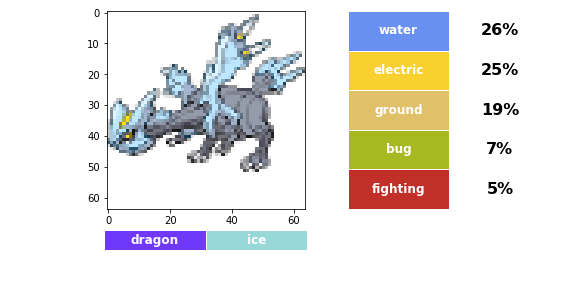

In [14]:
%matplotlib inline
from utility.load import *
from utility.plot import plot_sprite

def plot_prediction(model,pkm_id,sprite,type_dict = load_type_dict(),pkm_dict = load_pokemon_dict()):
    type_1 = pkm_dict[pkm_id]["type_01"]
    type_2 = pkm_dict[pkm_id]["type_02"]
    
    pred = model.predict(sprite.reshape((1,64,64,3))).flatten().tolist()
    pred = dict((idx+1, v) for idx, v in enumerate(pred))
    plot_sprite(sprite, type_1=type_1, type_2=type_2, pred=pred, type_dict = type_dict,save="{}.png".format(pkm_id))    
    
for pkm_id in df_test["id"].unique():
    df_filter = df.loc[
        (df["id"] == pkm_id) & 
        (df["gen"] == "gen05_black-white")
    ]                      
    sprite = df_filter["sprite"].iloc[0]
    plot_prediction(model,pkm_id,sprite)

For plotting the intermediate layers activations we must build a truncated model architecture from our original model, and get the activations as the output of this new model.

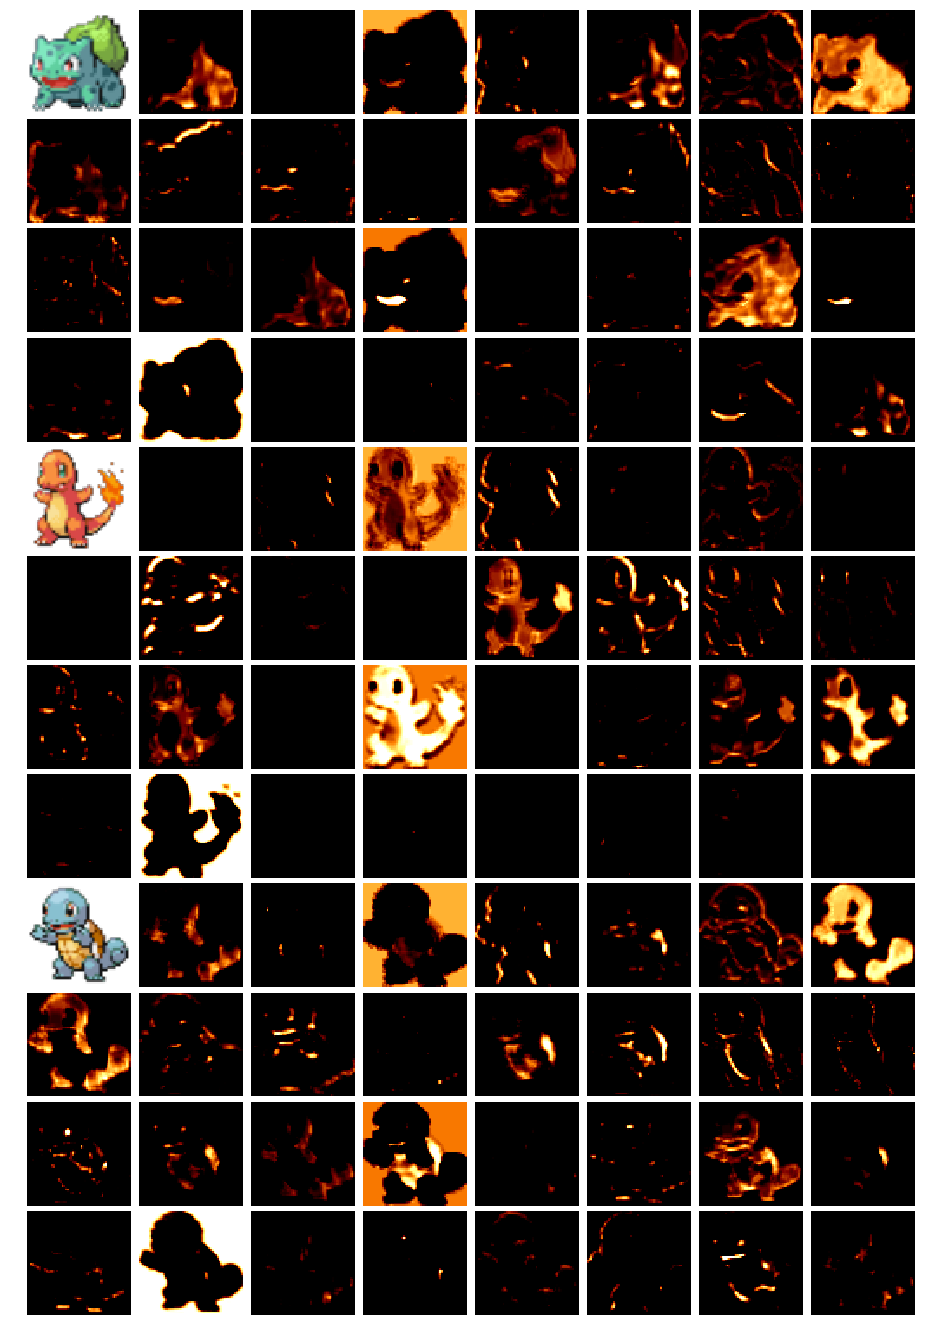

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout

#Defining model Architecture
model = Sequential([
        Convolution2D(32, 5, 5, input_shape=(64,64,3), dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
        
        Convolution2D(64, 5, 5, dim_ordering="tf"),
        Activation("relu"),
        MaxPooling2D((2,2)),
        
        Flatten(),
        
        Dense(64),
        Activation("relu"),
        Dense(18),
        Activation("softmax")
    ])

model.load_weights("./models/model_02.hdf5")

# we build a new model with the activations of the old model
# this model is truncated after the first layer
model_trunc = Sequential([
    Convolution2D(32, 5, 5, input_shape=(64,64,3), dim_ordering="tf", weights=model.layers[0].get_weights()),
    Activation("relu")
])

plt.figure(figsize=(16,24))
gs = gridspec.GridSpec(12,8)
gs.update(wspace=0.025, hspace=0.05)

for idx, j in enumerate([0,3,6]):
    activations = model_trunc.predict(df["sprite"].iloc[j].reshape(1,64,64,3))
    for i in range(0,32):        
        layer_filter = activations.reshape([60,60,32])[:,:,i]
        ax = plt.subplot(gs[32*idx+i])
        plt.axis("off")  
        if i == 0:
            plt.imshow(color.hsv2rgb(df["sprite"].iloc[j]))
        else:
            plt.imshow(layer_filter,cmap="afmhot",vmin=0, vmax=1)    
